<a href="https://colab.research.google.com/github/jamessutton600613-png/ColabsNotebooks/blob/main/Untitled305.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
from collections import defaultdict

# -------------------------
# Gates
# -------------------------
def seasonal(day, period=365, amp=0.0, phase=0.0):
    return 1.0 + amp * np.sin(2*np.pi*(day/period) + phase)

def diurnal(step, steps_per_day, amp=1.0, phase=-np.pi/2):
    raw = 1.0 + amp * np.sin(2*np.pi*(step/steps_per_day) + phase)
    return max(0.0, raw)

def gate_values(day, step, steps_per_day,
                seasonal_uv_amp=0.6, diurnal_uv_amp=1.0,
                seasonal_wet_amp=0.0, refuge=1.0):
    uv  = seasonal(day, amp=seasonal_uv_amp) * diurnal(step, steps_per_day, amp=diurnal_uv_amp) * refuge
    wet = seasonal(day, amp=seasonal_wet_amp, phase=np.pi/2)
    return wet, uv

# -------------------------
# Build sink-aware graph with tunable "competition knobs"
# -------------------------
def build_edges(k_radsq_capture=0.12, k_cdrf_capture=0.10,
                k_rf_to_lc=0.08, k_rf_to_lf=0.04):
    # Edge = (src, dst, gate_type, k, note)
    edges = [
        ("Start", "RF",   "wet", 0.08, "formation_pool"),

        # Radical backbone
        ("RF",  "RFT",  "uv",  0.06, "excitation"),
        ("RFT", "RFsq", "uv",  0.05, "radicalize"),
        ("RFsq","FMN",  "wet", k_radsq_capture, "capture_RFsq_to_FMN"),

        # CDRF backbone
        ("RF",   "CDRF", "uv",  0.05, "photoaddition_to_CDRF"),
        ("CDRF", "FMN",  "wet", k_cdrf_capture, "capture_CDRF_to_FMN"),

        # Canonical wet-only
        ("RF",  "FMN", "wet", 0.06, "direct_to_FMN"),
        ("FMN", "FAD", "wet", 0.06, "to_FAD"),

        # Sinks
        ("RF", "LC", "uv", k_rf_to_lc, "photolysis_to_LC"),
        ("RF", "LF", "uv", k_rf_to_lf, "photolysis_to_LF"),
        ("LC", "Dead", "uv", 0.03, "LC_to_dead"),
        ("LF", "Dead", "uv", 0.03, "LF_to_dead"),

        # Optional weak recycling
        ("LC", "RF", "wet", 0.003, "LC_recycle_to_RF"),
        ("LF", "RF", "wet", 0.002, "LF_recycle_to_RF"),

        # Adsorption protection (kept, but not part of route competition unless you want to sweep it)
        ("RF",    "AdsRF",  "wet", 0.10, "adsorb_RF"),
        ("AdsRF", "RF",     "wet", 0.06, "desorb_RF"),
        ("FMN",   "AdsFMN", "wet", 0.08, "adsorb_FMN"),
        ("AdsFMN","FMN",    "wet", 0.05, "desorb_FMN"),
        ("FAD",   "AdsFAD", "wet", 0.06, "adsorb_FAD"),
        ("AdsFAD","FAD",    "wet", 0.04, "desorb_FAD"),

        # UV losses (reduced in Ads states)
        ("RF",    "Dead", "uv", 0.01,  "RF_uv_loss"),
        ("FMN",   "Dead", "uv", 0.015, "FMN_uv_loss"),
        ("FAD",   "Dead", "uv", 0.01,  "FAD_uv_loss"),
        ("AdsRF", "Dead", "uv", 0.001, "AdsRF_uv_loss_low"),
        ("AdsFMN","Dead", "uv", 0.001, "AdsFMN_uv_loss_low"),
        ("AdsFAD","Dead", "uv", 0.001, "AdsFAD_uv_loss_low"),
    ]
    return edges

# -------------------------
# Enumerate routes Start -> FAD (excluding Dead)
# -------------------------
def enumerate_paths(edges, start="Start", goal="FAD", max_len=14):
    allowed = set([u for (u,_,_,_,_) in edges] + [v for (_,v,_,_,_) in edges]) - {"Dead"}
    adj = defaultdict(list)
    edge_meta = {}
    for (u,v,gt,k,note) in edges:
        if u in allowed and v in allowed:
            adj[u].append(v)
            edge_meta[(u,v)] = (gt,float(k),note)

    paths = []
    stack = [(start, [start])]
    while stack:
        node, path = stack.pop()
        if node == goal:
            paths.append(path)
            continue
        if len(path) >= max_len:
            continue
        for nxt in adj.get(node, []):
            if nxt in path:
                continue
            stack.append((nxt, path + [nxt]))
    return paths, edge_meta

# -------------------------
# AOI edge weights and transition probabilities
# -------------------------
def edge_weights(edge_meta, protocol="AB", days=365, steps_per_day=200,
                 seasonal_uv_amp=0.6, diurnal_uv_amp=1.0, seasonal_wet_amp=0.0, refuge=1.0):
    dt = 1.0 / steps_per_day
    half = steps_per_day // 2
    W = {e: 0.0 for e in edge_meta.keys()}

    for day in range(days):
        for step in range(steps_per_day):
            wet, uv = gate_values(day, step, steps_per_day,
                                  seasonal_uv_amp=seasonal_uv_amp,
                                  diurnal_uv_amp=diurnal_uv_amp,
                                  seasonal_wet_amp=seasonal_wet_amp,
                                  refuge=refuge)
            gate = protocol[0] if step < half else protocol[1]
            wet_eff = (wet if gate == "A" else 0.0)
            uv_eff  = (uv  if gate == "B" else 0.0)

            for (u,v),(gt,k,note) in edge_meta.items():
                g = wet_eff if gt == "wet" else (uv_eff if gt == "uv" else 1.0)
                W[(u,v)] += k * g * dt
    return W

def transition_probs(W):
    out_sum = defaultdict(float)
    for (u,v), w in W.items():
        out_sum[u] += w
    P = {}
    for (u,v), w in W.items():
        denom = out_sum[u]
        P[(u,v)] = (w / denom) if denom > 0 else 0.0
    return P

def path_prob(path, P):
    p = 1.0
    for i in range(len(path)-1):
        p *= P[(path[i], path[i+1])]
    return p

def family_of(path_nodes):
    nodes = set(path_nodes)
    if ("RFT" in nodes) or ("RFsq" in nodes):
        return "radical_family"
    if "CDRF" in nodes:
        return "cdrf_family"
    # canonical: reaches FAD without radical/CDRF
    return "canonical_family"

def run_env_competition(edges, env_kwargs):
    paths, edge_meta = enumerate_paths(edges)

    W_AB = edge_weights(edge_meta, protocol="AB", **env_kwargs)
    W_BA = edge_weights(edge_meta, protocol="BA", **env_kwargs)
    P_AB = transition_probs(W_AB)
    P_BA = transition_probs(W_BA)

    fam = defaultdict(lambda: {"P_AB":0.0, "P_BA":0.0, "best_route_AB":None, "bestP_AB":-1.0,
                              "best_route_BA":None, "bestP_BA":-1.0})

    for p in paths:
        pab = path_prob(p, P_AB)
        pba = path_prob(p, P_BA)
        f = family_of(p)
        fam[f]["P_AB"] += pab
        fam[f]["P_BA"] += pba
        if pab > fam[f]["bestP_AB"]:
            fam[f]["bestP_AB"] = pab
            fam[f]["best_route_AB"] = " -> ".join(p)
        if pba > fam[f]["bestP_BA"]:
            fam[f]["bestP_BA"] = pba
            fam[f]["best_route_BA"] = " -> ".join(p)

    # Make a tidy table
    rows = []
    for f in ["radical_family", "cdrf_family", "canonical_family"]:
        Pab = fam[f]["P_AB"]
        Pba = fam[f]["P_BA"]
        rows.append({
            "family": f,
            "P_AB_total": Pab,
            "P_BA_total": Pba,
            "DeltaP_total": Pab - Pba,
            "Ratio_AB_over_BA": (Pab / Pba) if Pba > 0 else np.inf,
            "best_route_AB": fam[f]["best_route_AB"],
            "bestP_AB": fam[f]["bestP_AB"],
            "best_route_BA": fam[f]["best_route_BA"],
            "bestP_BA": fam[f]["bestP_BA"],
        })
    return pd.DataFrame(rows)

# -------------------------
# Sweep: competition knobs
# -------------------------
envs = {
    "equator_exposed": dict(days=365, steps_per_day=200, seasonal_uv_amp=0.6, diurnal_uv_amp=1.0, seasonal_wet_amp=0.0, refuge=1.0),
    "refuge": dict(days=365, steps_per_day=200, seasonal_uv_amp=0.6, diurnal_uv_amp=1.0, seasonal_wet_amp=0.0, refuge=0.3),
    "wet_season_refuge": dict(days=365, steps_per_day=200, seasonal_uv_amp=0.6, diurnal_uv_amp=1.0, seasonal_wet_amp=0.6, refuge=0.3),
}

# Sweep capture efficiencies: radical capture vs CDRF capture
radical_caps = [0.05, 0.08, 0.12, 0.16]
cdrf_caps    = [0.05, 0.08, 0.10, 0.14]

# Sweep sink strength (how hard RF gets siphoned into LC/LF)
sink_levels = [
    (0.04, 0.02),  # mild sinks
    (0.08, 0.04),  # baseline (what you used)
    (0.12, 0.06),  # harsh sinks
]

rows = []
for (k_lc, k_lf) in sink_levels:
    for k_rad in radical_caps:
        for k_cdrf in cdrf_caps:
            edges = build_edges(k_radsq_capture=k_rad, k_cdrf_capture=k_cdrf,
                                k_rf_to_lc=k_lc, k_rf_to_lf=k_lf)
            for env_name, env_kwargs in envs.items():
                tab = run_env_competition(edges, env_kwargs)
                # Competition metric: AB_total(radical) / AB_total(cdrf)
                rad_ab = float(tab.loc[tab["family"]=="radical_family", "P_AB_total"].iloc[0])
                cdr_ab = float(tab.loc[tab["family"]=="cdrf_family", "P_AB_total"].iloc[0])
                comp = (rad_ab / cdr_ab) if cdr_ab > 0 else np.inf

                rows.append({
                    "env": env_name,
                    "k_rad_capture": k_rad,
                    "k_cdrf_capture": k_cdrf,
                    "k_sink_LC": k_lc,
                    "k_sink_LF": k_lf,
                    "rad_AB_total": rad_ab,
                    "cdrf_AB_total": cdr_ab,
                    "rad_over_cdrf_AB": comp,
                    "rad_DeltaP": float(tab.loc[tab["family"]=="radical_family", "DeltaP_total"].iloc[0]),
                    "cdrf_DeltaP": float(tab.loc[tab["family"]=="cdrf_family", "DeltaP_total"].iloc[0]),
                })

df = pd.DataFrame(rows)
df.to_csv("FAD_competition_sweep.csv", index=False)

# Quick “winners” summary: in each environment, what fraction of sweep points have radical > CDRF?
summary = (df.assign(rad_wins = df["rad_over_cdrf_AB"] > 1.0)
             .groupby("env")["rad_wins"].mean()
             .reset_index()
             .rename(columns={"rad_wins":"fraction_radical_wins"}))

print("Saved: FAD_competition_sweep.csv\n")
print(summary.to_string(index=False))

# Show top 15 most radical-dominant points in refuge (as an example)
sub = df[df["env"]=="refuge"].sort_values("rad_over_cdrf_AB", ascending=False).head(15)
print("\nTop 15 (refuge) by radical dominance (AB):")
print(sub.to_string(index=False))

Saved: FAD_competition_sweep.csv

              env  fraction_radical_wins
  equator_exposed                    1.0
           refuge                    1.0
wet_season_refuge                    1.0

Top 15 (refuge) by radical dominance (AB):
   env  k_rad_capture  k_cdrf_capture  k_sink_LC  k_sink_LF  rad_AB_total  cdrf_AB_total  rad_over_cdrf_AB  rad_DeltaP  cdrf_DeltaP
refuge           0.16            0.14       0.08       0.04      0.033921       0.028268               1.2    0.000471     0.000392
refuge           0.16            0.10       0.08       0.04      0.033921       0.028268               1.2    0.000471     0.000392
refuge           0.16            0.08       0.08       0.04      0.033921       0.028268               1.2    0.000471     0.000392
refuge           0.16            0.05       0.08       0.04      0.033921       0.028268               1.2    0.000471     0.000392
refuge           0.12            0.14       0.08       0.04      0.033921       0.028268          

Columns: ['env', 'k_rad_capture', 'k_cdrf_capture', 'k_sink_LC', 'k_sink_LF', 'rad_AB_total', 'cdrf_AB_total', 'rad_over_cdrf_AB', 'rad_DeltaP', 'cdrf_DeltaP']


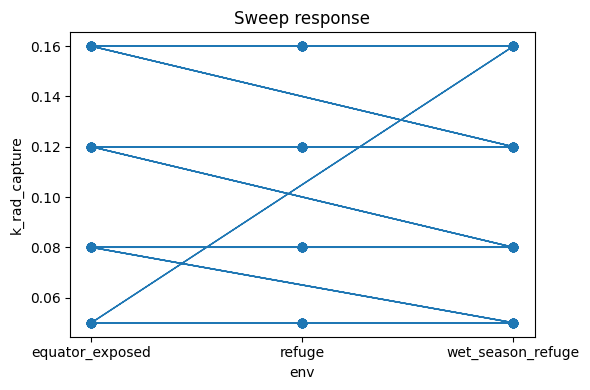

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# ---- config ----
path = "/content/FAD_competition_sweep.csv"   # or .npz
outdir = Path("figures")
outdir.mkdir(exist_ok=True)

# ---- load ----
if path.endswith(".csv"):
    df = pd.read_csv(path)
elif path.endswith(".npz"):
    data = np.load(path)
    df = pd.DataFrame({k: data[k] for k in data.files})
else:
    raise ValueError("Unsupported file type")

print("Columns:", list(df.columns))

# ---- example plot: first two columns ----
x = df.iloc[:, 0]
y = df.iloc[:, 1]

plt.figure(figsize=(6,4))
plt.plot(x, y, marker="o", linewidth=1)
plt.xlabel(df.columns[0])
plt.ylabel(df.columns[1])
plt.title("Sweep response")
plt.tight_layout()

plt.savefig(outdir / "fig1_sweep.pdf")
plt.savefig(outdir / "fig1_sweep.png", dpi=300)
plt.show()

In [ ]:
import pandas as pd

df = pd.read_csv("/content/FAD_competition_sweep.csv")
df.head(), df.dtypes, df.columns

(                 env  k_rad_capture  k_cdrf_capture  k_sink_LC  k_sink_LF  \
 0    equator_exposed           0.05            0.05       0.04       0.02   
 1             refuge           0.05            0.05       0.04       0.02   
 2  wet_season_refuge           0.05            0.05       0.04       0.02   
 3    equator_exposed           0.05            0.08       0.04       0.02   
 4             refuge           0.05            0.08       0.04       0.02   
 
    rad_AB_total  cdrf_AB_total  rad_over_cdrf_AB  rad_DeltaP  cdrf_DeltaP  
 0      0.078298       0.065248               1.2    0.000756     0.000630  
 1      0.036837       0.030698               1.2    0.000554     0.000462  
 2      0.036837       0.030698               1.2    0.000554     0.000462  
 3      0.078298       0.065248               1.2    0.000756     0.000630  
 4      0.036837       0.030698               1.2    0.000554     0.000462  ,
 env                  object
 k_rad_capture       float64
 k_cdrf_c

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

df = pd.read_csv("/content/FAD_competition_sweep.csv")

outdir = Path("figures")
outdir.mkdir(exist_ok=True)

env_order = ["equator_exposed", "refuge", "wet_season_refuge"]
df["env"] = pd.Categorical(df["env"], categories=env_order, ordered=True)

In [ ]:
def strip_by_env(ycol, title=None, fname=None, seed=0):
    cats = list(df["env"].cat.categories)
    xmap = {c:i for i,c in enumerate(cats)}
    x = df["env"].map(xmap).astype(float).to_numpy()
    y = df[ycol].astype(float).to_numpy()

    rng = np.random.default_rng(seed)
    jitter = rng.normal(0, 0.06, size=len(x))

    plt.figure(figsize=(6,4))
    plt.scatter(x + jitter, y, s=25, alpha=0.8)
    plt.xticks(range(len(cats)), cats, rotation=20, ha="right")
    plt.xlabel("env")
    plt.ylabel(ycol)
    plt.title(title if title else f"{ycol} by env (strip)")
    plt.tight_layout()

    fn = fname if fname else f"strip_{ycol}"
    plt.savefig(outdir / f"{fn}.pdf")
    plt.savefig(outdir / f"{fn}.png", dpi=300)
    plt.show()

In [ ]:
def mean_sd_by_env(ycol, title=None, fname=None):
    g = df.groupby("env")[ycol].agg(["mean","std","count"]).reindex(df["env"].cat.categories)
    x = np.arange(len(g.index))

    plt.figure(figsize=(6,4))
    plt.errorbar(x, g["mean"].to_numpy(), yerr=g["std"].to_numpy(), fmt="o", capsize=4)
    plt.xticks(x, g.index.tolist(), rotation=20, ha="right")
    plt.xlabel("env")
    plt.ylabel(ycol)
    plt.title(title if title else f"{ycol} by env (mean ± SD)")
    plt.tight_layout()

    fn = fname if fname else f"mean_sd_{ycol}"
    plt.savefig(outdir / f"{fn}.pdf")
    plt.savefig(outdir / f"{fn}.png", dpi=300)
    plt.show()

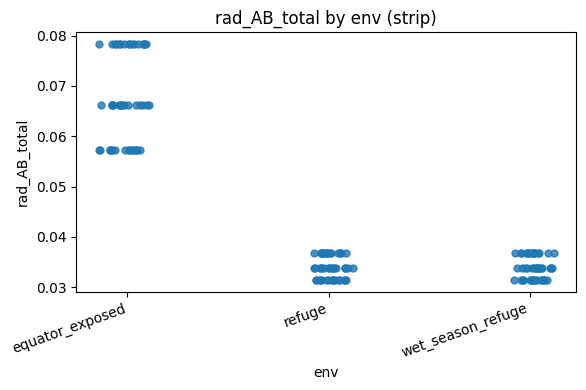

/tmp/ipython-input-2631517843.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = df.groupby("env")[ycol].agg(["mean","std","count"]).reindex(df["env"].cat.categories)


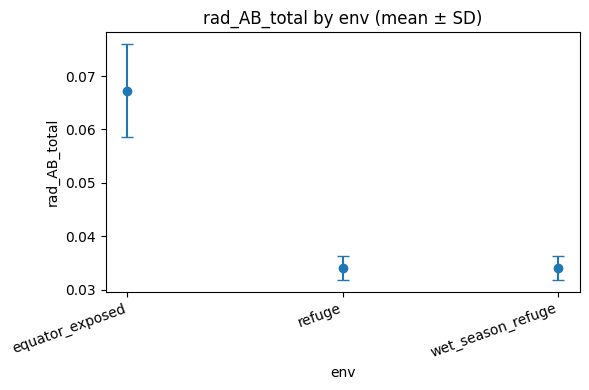

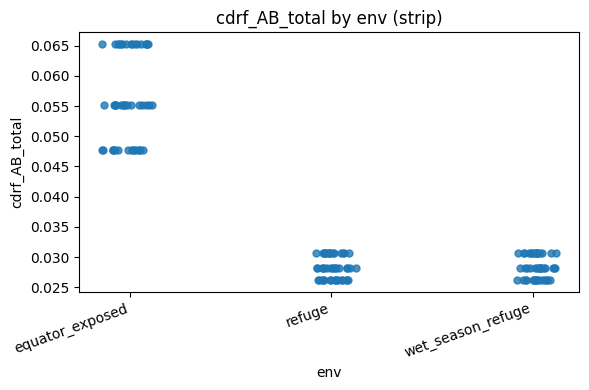

/tmp/ipython-input-2631517843.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = df.groupby("env")[ycol].agg(["mean","std","count"]).reindex(df["env"].cat.categories)


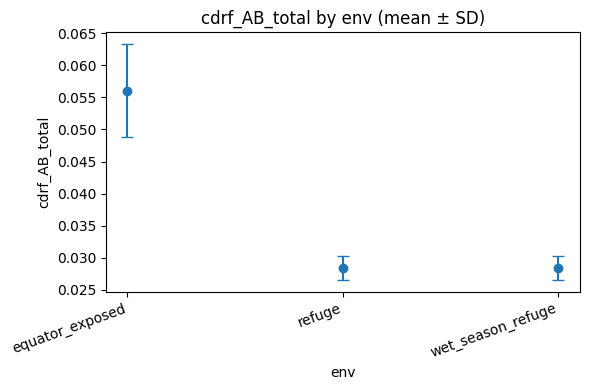

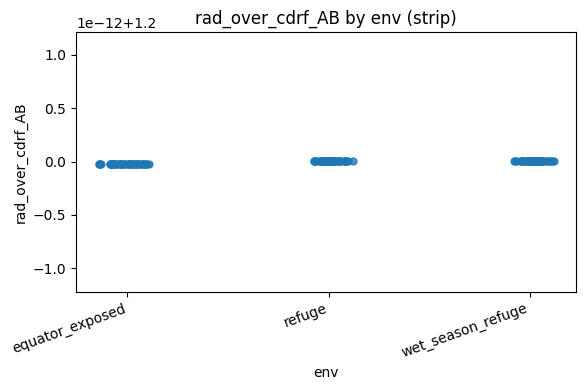

/tmp/ipython-input-2631517843.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = df.groupby("env")[ycol].agg(["mean","std","count"]).reindex(df["env"].cat.categories)


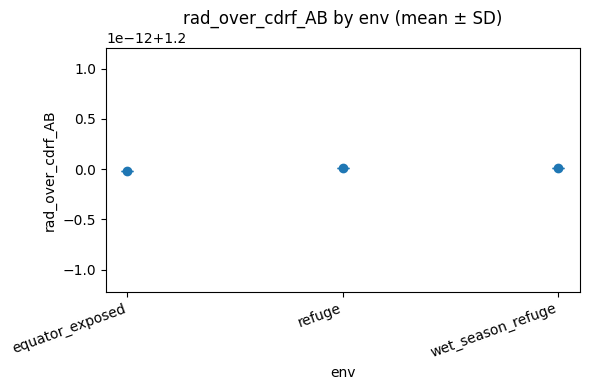

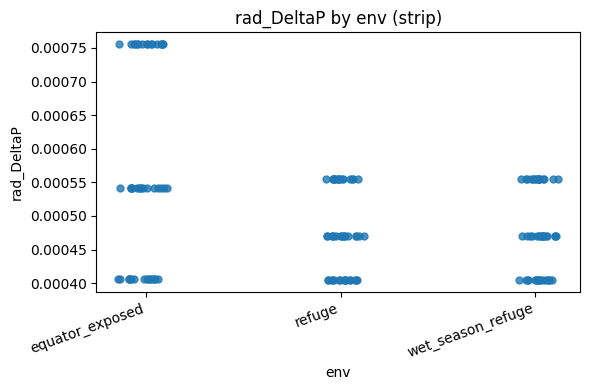

/tmp/ipython-input-2631517843.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = df.groupby("env")[ycol].agg(["mean","std","count"]).reindex(df["env"].cat.categories)


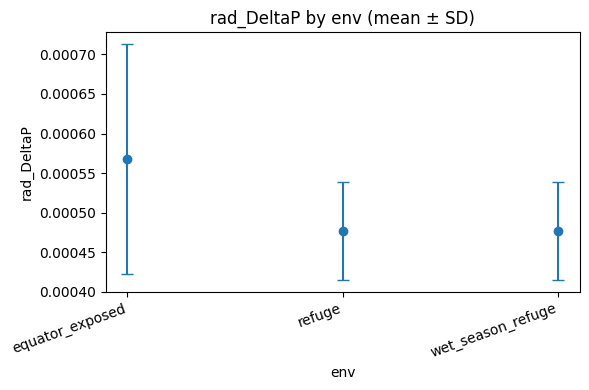

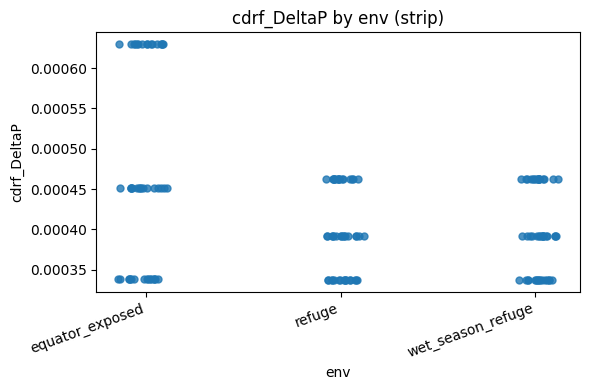

/tmp/ipython-input-2631517843.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = df.groupby("env")[ycol].agg(["mean","std","count"]).reindex(df["env"].cat.categories)


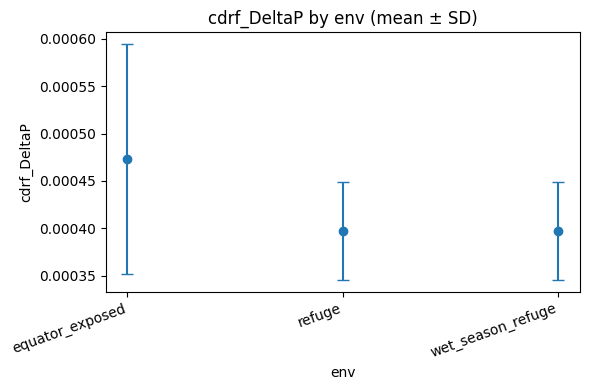

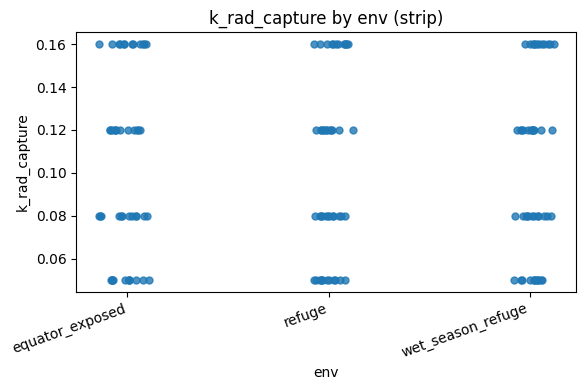

/tmp/ipython-input-2631517843.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = df.groupby("env")[ycol].agg(["mean","std","count"]).reindex(df["env"].cat.categories)


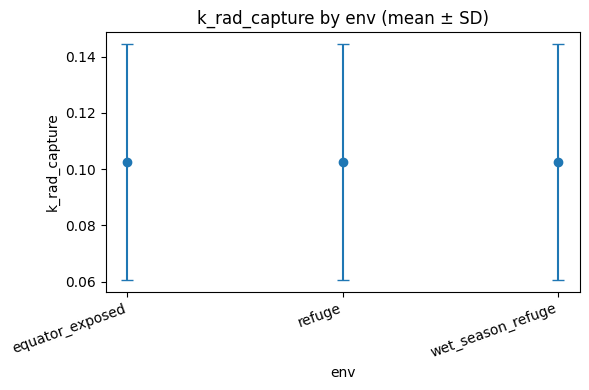

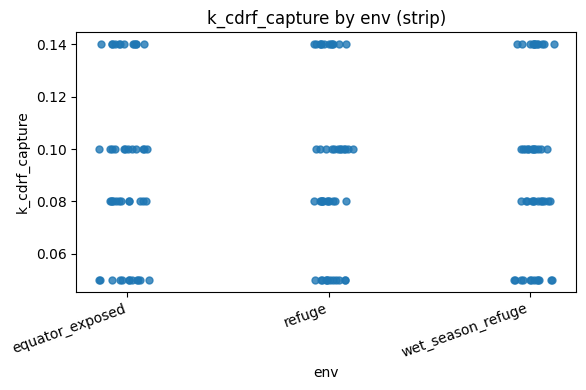

/tmp/ipython-input-2631517843.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = df.groupby("env")[ycol].agg(["mean","std","count"]).reindex(df["env"].cat.categories)


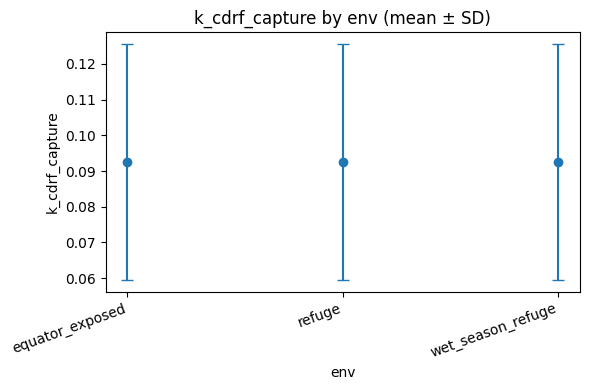

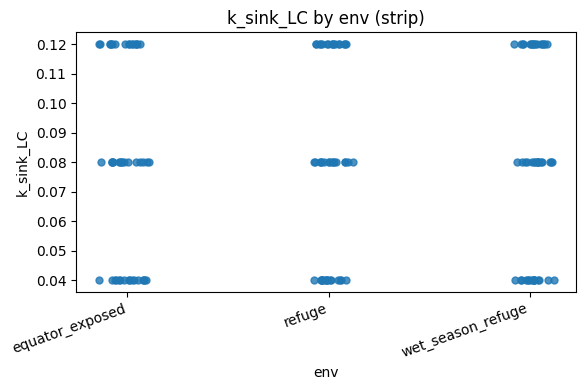

/tmp/ipython-input-2631517843.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = df.groupby("env")[ycol].agg(["mean","std","count"]).reindex(df["env"].cat.categories)


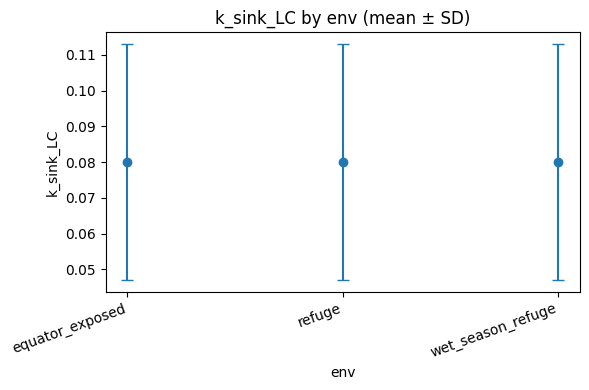

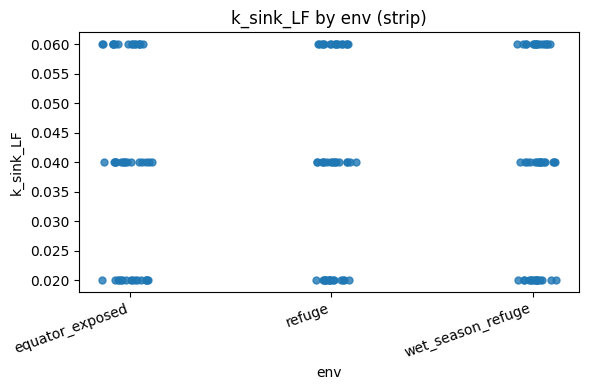

/tmp/ipython-input-2631517843.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = df.groupby("env")[ycol].agg(["mean","std","count"]).reindex(df["env"].cat.categories)


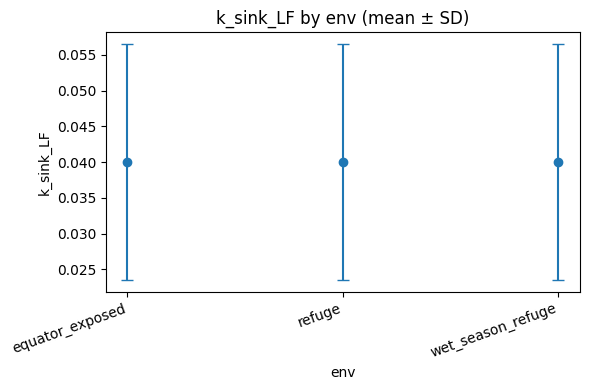

In [ ]:
metrics = [
    "rad_AB_total",
    "cdrf_AB_total",
    "rad_over_cdrf_AB",
    "rad_DeltaP",
    "cdrf_DeltaP",
    "k_rad_capture",
    "k_cdrf_capture",
    "k_sink_LC",
    "k_sink_LF",
]

for m in metrics:
    strip_by_env(m, fname=f"fig_{m}_strip")
    mean_sd_by_env(m, fname=f"fig_{m}_mean_sd")

In [ ]:
import shutil
from pathlib import Path

figdir = Path("figures")
zip_path = Path("figures.zip")

if zip_path.exists():
    zip_path.unlink()

shutil.make_archive("figures", "zip", figdir)
print("Created:", zip_path)

Created: figures.zip


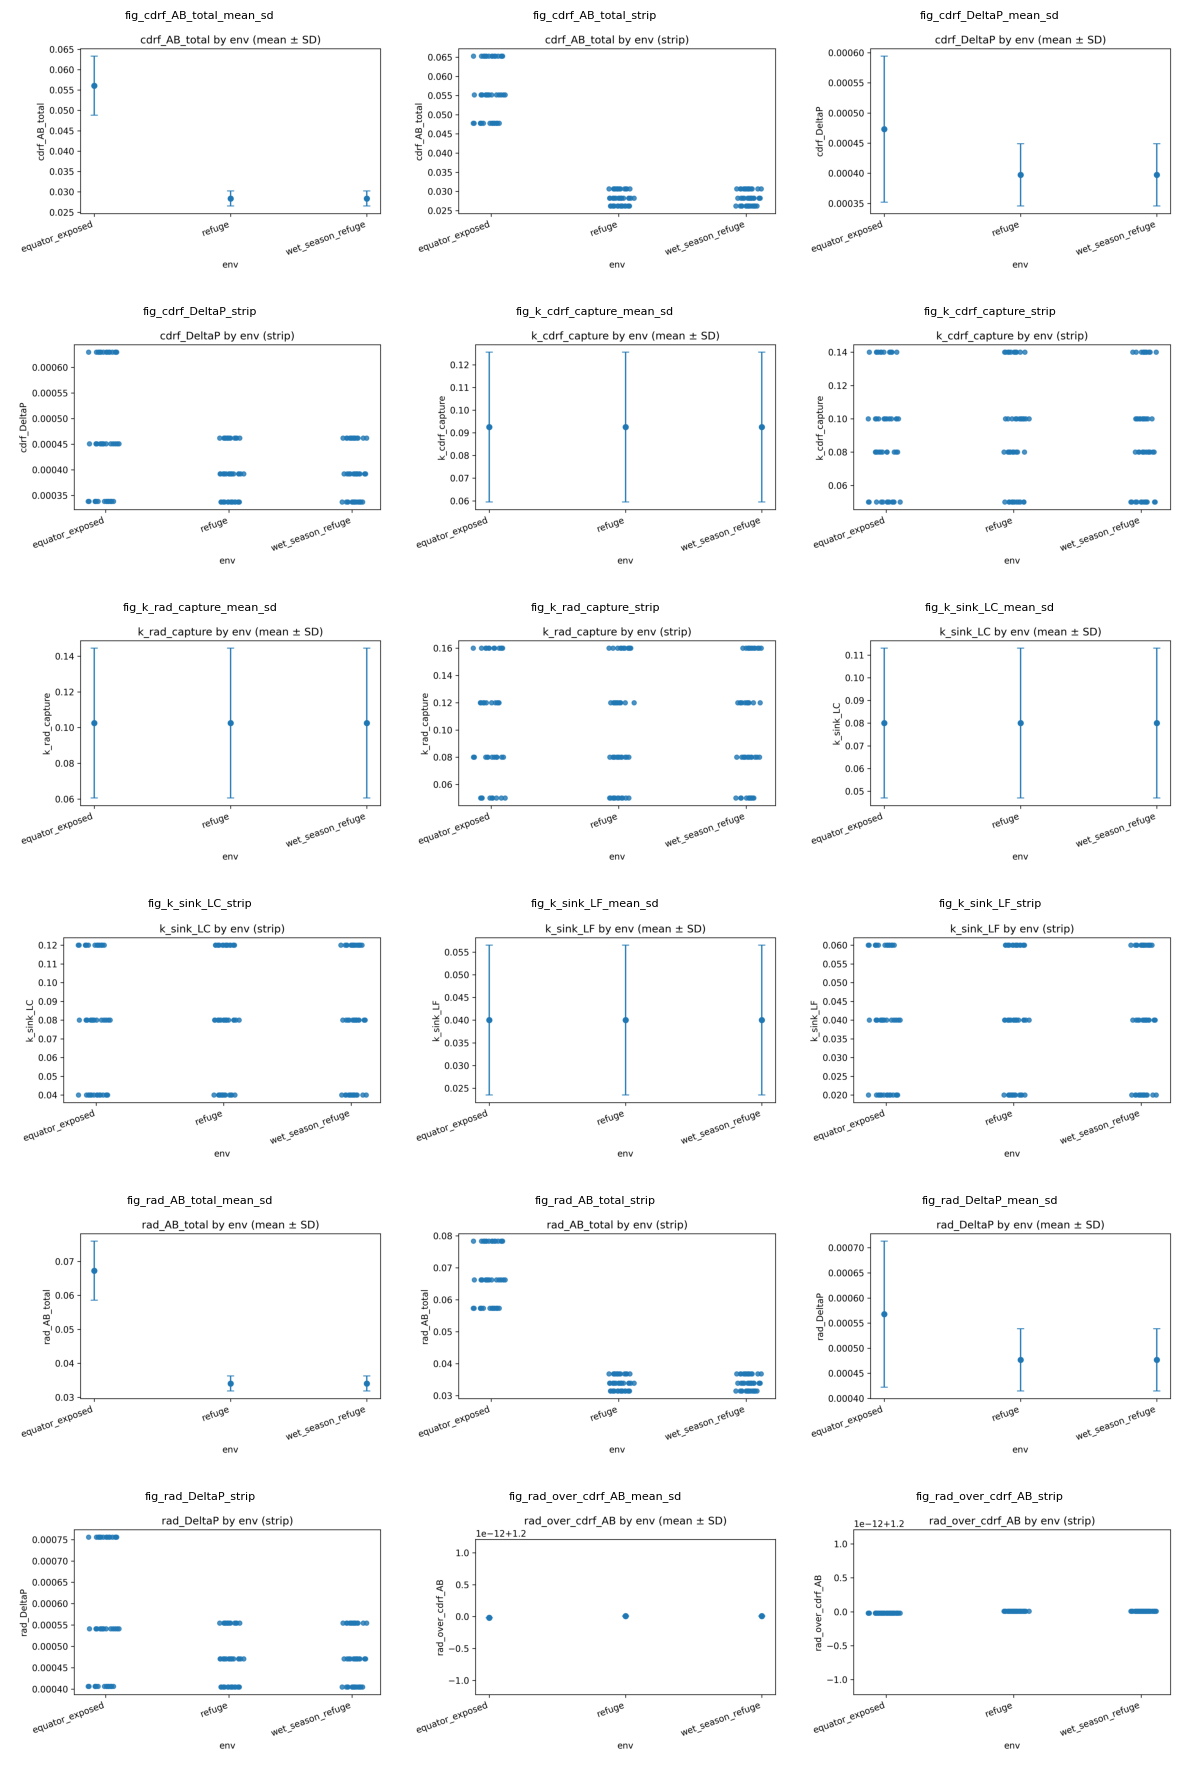

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path
import math

figdir = Path("figures")
imgs = sorted(figdir.glob("*.png"))

n = len(imgs)
cols = 3
rows = math.ceil(n / cols)

plt.figure(figsize=(cols*4, rows*3))

for i, img_path in enumerate(imgs, start=1):
    img = Image.open(img_path)
    ax = plt.subplot(rows, cols, i)
    ax.imshow(img)
    ax.axis("off")
    ax.set_title(img_path.stem, fontsize=8)

plt.tight_layout()
plt.savefig(figdir / "panel_all_figures.pdf")
plt.savefig(figdir / "panel_all_figures.png", dpi=300)
plt.show()

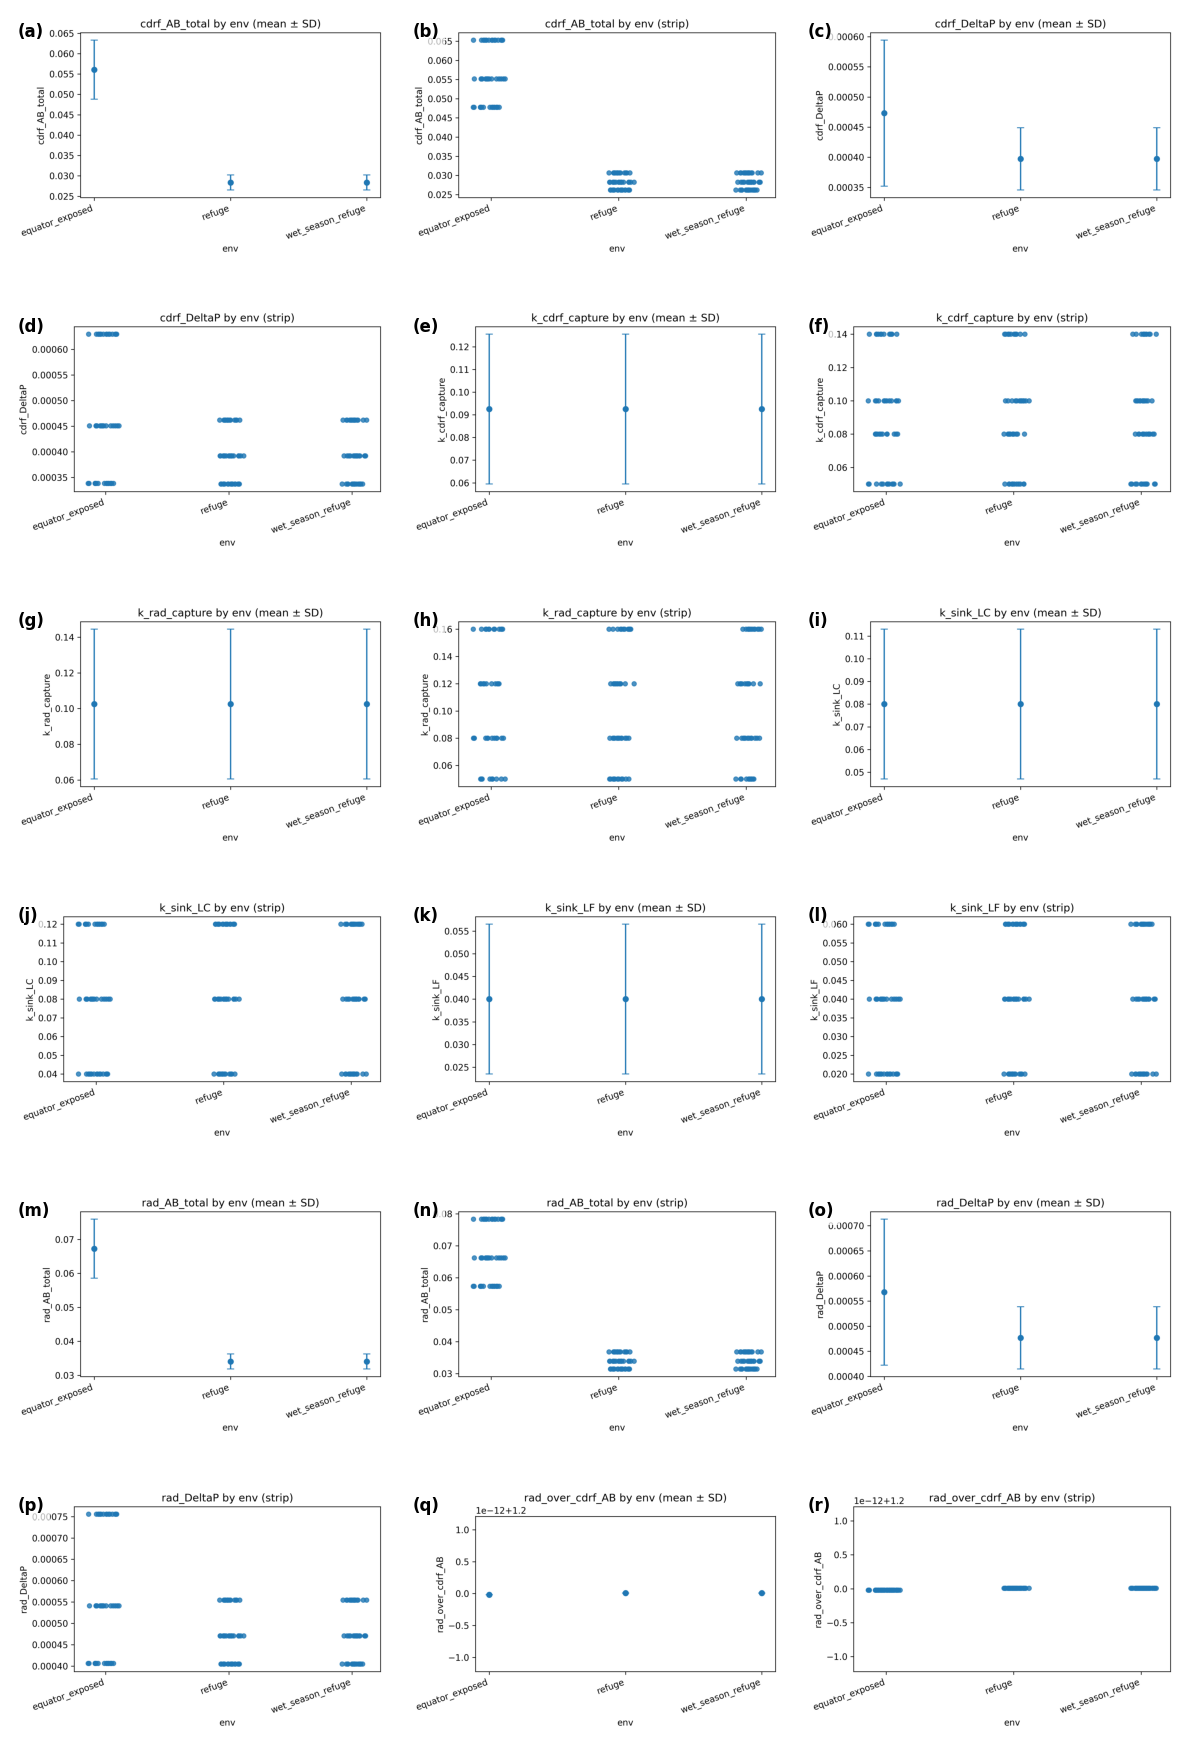

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path
import math
import string

figdir = Path("figures")
imgs = sorted(figdir.glob("*.png"))

n = len(imgs)
cols = 3
rows = math.ceil(n / cols)

labels = list(string.ascii_lowercase)

plt.figure(figsize=(cols*4, rows*3))

for i, img_path in enumerate(imgs):
    img = Image.open(img_path)
    ax = plt.subplot(rows, cols, i + 1)
    ax.imshow(img)
    ax.axis("off")

    # subfigure label (a), (b), (c) ...
    lbl = labels[i] if i < len(labels) else f"({i+1})"
    ax.text(
        0.02, 0.95,
        f"({lbl})",
        transform=ax.transAxes,
        fontsize=12,
        fontweight="bold",
        va="top",
        ha="left",
        bbox=dict(facecolor="white", edgecolor="none", alpha=0.7)
    )

plt.tight_layout()
plt.savefig(figdir / "panel_all_figures_labeled.pdf")
plt.savefig(figdir / "panel_all_figures_labeled.png", dpi=300)
plt.show()

In [ ]:
import numpy as np
import pandas as pd
from collections import defaultdict

# ---------- Gates ----------
def seasonal(day, period=365, amp=0.6, phase=0.0):
    return 1.0 + amp * np.sin(2*np.pi*(day/period) + phase)

def diurnal(step, steps_per_day, amp=1.0, phase=-np.pi/2):
    raw = 1.0 + amp * np.sin(2*np.pi*(step/steps_per_day) + phase)
    return max(0.0, raw)

def gate_values(day, step, steps_per_day,
                seasonal_uv_amp=0.6, diurnal_uv_amp=1.0,
                seasonal_wet_amp=0.0, refuge=1.0):
    uv  = seasonal(day, amp=seasonal_uv_amp) * diurnal(step, steps_per_day, amp=diurnal_uv_amp) * refuge
    wet = seasonal(day, amp=seasonal_wet_amp, phase=np.pi/2)
    return wet, uv

# ---------- Build sink-aware graph (same structure as before) ----------
def build_edges():
    # Edge = (src, dst, gate_type, k, note)
    edges = [
        ("Start", "RF",   "wet", 0.08, "formation"),

        ("RF",  "RFT",  "uv",  0.06, "excitation"),
        ("RFT", "RFsq", "uv",  0.05, "radicalize"),
        ("RFsq","FMN",  "wet", 0.12, "capture_RFsq_to_FMN"),

        ("RF",   "CDRF", "uv",  0.05, "photoaddition_to_CDRF"),
        ("CDRF", "FMN",  "wet", 0.10, "capture_CDRF_to_FMN"),

        ("RF",  "FMN", "wet", 0.06, "direct_to_FMN"),
        ("FMN", "FAD", "wet", 0.06, "to_FAD"),

        # Sinks (photolysis)
        ("RF", "LC", "uv", 0.08, "photolysis_to_LC"),
        ("RF", "LF", "uv", 0.04, "photolysis_to_LF"),
        ("LC", "Dead", "uv", 0.03, "LC_to_dead"),
        ("LF", "Dead", "uv", 0.03, "LF_to_dead"),

        # weak recycling
        ("LC", "RF", "wet", 0.003, "LC_recycle_to_RF"),
        ("LF", "RF", "wet", 0.002, "LF_recycle_to_RF"),

        # Adsorption protection
        ("RF",    "AdsRF",  "wet", 0.10, "adsorb_RF"),
        ("AdsRF", "RF",     "wet", 0.06, "desorb_RF"),
        ("FMN",   "AdsFMN", "wet", 0.08, "adsorb_FMN"),
        ("AdsFMN","FMN",    "wet", 0.05, "desorb_FMN"),
        ("FAD",   "AdsFAD", "wet", 0.06, "adsorb_FAD"),
        ("AdsFAD","FAD",    "wet", 0.04, "desorb_FAD"),

        # UV losses (lower in Ads)
        ("RF",    "Dead", "uv", 0.01,  "RF_uv_loss"),
        ("FMN",   "Dead", "uv", 0.015, "FMN_uv_loss"),
        ("FAD",   "Dead", "uv", 0.01,  "FAD_uv_loss"),
        ("AdsRF", "Dead", "uv", 0.001, "AdsRF_uv_loss_low"),
        ("AdsFMN","Dead", "uv", 0.001, "AdsFMN_uv_loss_low"),
        ("AdsFAD","Dead", "uv", 0.001, "AdsFAD_uv_loss_low"),
    ]
    return edges

# ---------- Route enumeration (Start -> FAD) excluding Dead ----------
def enumerate_paths(edges, start="Start", goal="FAD", max_len=14):
    allowed = set([u for (u,_,_,_,_) in edges] + [v for (_,v,_,_,_) in edges]) - {"Dead"}
    adj = defaultdict(list)
    edge_meta = {}
    for (u,v,gt,k,note) in edges:
        if u in allowed and v in allowed:
            adj[u].append(v)
            edge_meta[(u,v)] = (gt,float(k),note)

    paths = []
    stack = [(start, [start])]
    while stack:
        node, path = stack.pop()
        if node == goal:
            paths.append(path)
            continue
        if len(path) >= max_len:
            continue
        for nxt in adj.get(node, []):
            if nxt in path:
                continue
            stack.append((nxt, path + [nxt]))
    return paths, edge_meta

# ---------- AOI weights, with chirality leverage ----------
def edge_weights(edge_meta, protocol="AB", days=365, steps_per_day=200,
                 seasonal_uv_amp=0.6, diurnal_uv_amp=1.0,
                 seasonal_wet_amp=0.0, refuge=1.0,
                 chi=None, beta_capture=0.0, gamma_sink=0.0):
    """
    chi: dict node->chirality leverage in [0,1] (agnostic weights)
    beta_capture: boosts wet-capture edges into chiral nodes or from chiral nodes
    gamma_sink: reduces UV-loss edges for chiral nodes (protective leverage)
    """
    if chi is None:
        chi = {}

    dt = 1.0 / steps_per_day
    half = steps_per_day // 2
    W = {e: 0.0 for e in edge_meta.keys()}

    for day in range(days):
        for step in range(steps_per_day):
            wet, uv = gate_values(day, step, steps_per_day,
                                  seasonal_uv_amp=seasonal_uv_amp,
                                  diurnal_uv_amp=diurnal_uv_amp,
                                  seasonal_wet_amp=seasonal_wet_amp,
                                  refuge=refuge)
            gate = protocol[0] if step < half else protocol[1]
            wet_eff = wet if gate == "A" else 0.0
            uv_eff  = uv  if gate == "B" else 0.0

            for (u,v),(gt,k,note) in edge_meta.items():
                g = wet_eff if gt == "wet" else (uv_eff if gt == "uv" else 1.0)
                if g <= 0:
                    continue

                k_eff = k

                # If this is a wet "capture-like" edge, allow chirality to boost it
                if gt == "wet":
                    cu = chi.get(u, 0.0)
                    cv = chi.get(v, 0.0)
                    k_eff = k_eff * (1.0 + beta_capture * max(cu, cv))

                # If this is a UV sink/loss to Dead, allow chirality to protect it
                if gt == "uv" and v == "Dead":
                    cu = chi.get(u, 0.0)
                    k_eff = k_eff * (1.0 - gamma_sink * cu)
                    if k_eff < 0:
                        k_eff = 0.0

                W[(u,v)] += k_eff * g * dt

    return W

def transition_probs(W):
    out_sum = defaultdict(float)
    for (u,v), w in W.items():
        out_sum[u] += w
    P = {}
    for (u,v), w in W.items():
        denom = out_sum[u]
        P[(u,v)] = (w / denom) if denom > 0 else 0.0
    return P

def path_prob(path, P):
    p = 1.0
    for i in range(len(path)-1):
        p *= P[(path[i], path[i+1])]
    return p

def family_of(nodes):
    s = set(nodes)
    if ("RFT" in s) or ("RFsq" in s):
        return "radical_family"
    if "CDRF" in s:
        return "cdrf_family"
    return "canonical_family"

def run_chi_sweep(env_name, env_kwargs, chi_target="RFsq",
                  chi_values=(0.0,0.25,0.5,0.75,1.0),
                  beta_values=(0.0,0.5,1.0,2.0),
                  gamma_values=(0.0,0.25,0.5,0.75)):
    edges = build_edges()
    paths, edge_meta = enumerate_paths(edges)

    rows = []
    for chi_val in chi_values:
        chi = {chi_target: chi_val}

        for beta in beta_values:
            for gamma in gamma_values:
                W_AB = edge_weights(edge_meta, protocol="AB", chi=chi, beta_capture=beta, gamma_sink=gamma, **env_kwargs)
                W_BA = edge_weights(edge_meta, protocol="BA", chi=chi, beta_capture=beta, gamma_sink=gamma, **env_kwargs)
                P_AB = transition_probs(W_AB)
                P_BA = transition_probs(W_BA)

                fam = defaultdict(lambda: {"P_AB":0.0, "P_BA":0.0})
                for p in paths:
                    pab = path_prob(p, P_AB)
                    pba = path_prob(p, P_BA)
                    f = family_of(p)
                    fam[f]["P_AB"] += pab
                    fam[f]["P_BA"] += pba

                rad_ab = fam["radical_family"]["P_AB"]
                cdr_ab = fam["cdrf_family"]["P_AB"]
                can_ab = fam["canonical_family"]["P_AB"]

                rad_gap = fam["radical_family"]["P_AB"] - fam["radical_family"]["P_BA"]
                cdr_gap = fam["cdrf_family"]["P_AB"] - fam["cdrf_family"]["P_BA"]
                can_gap = fam["canonical_family"]["P_AB"] - fam["canonical_family"]["P_BA"]

                rows.append({
                    "env": env_name,
                    "chi_target": chi_target,
                    "chi": chi_val,
                    "beta_capture": beta,
                    "gamma_sink": gamma,
                    "rad_AB": rad_ab,
                    "cdrf_AB": cdr_ab,
                    "canonical_AB": can_ab,
                    "rad_over_cdrf_AB": (rad_ab / cdr_ab) if cdr_ab > 0 else np.inf,
                    "rad_DeltaP": rad_gap,
                    "cdrf_DeltaP": cdr_gap,
                    "canonical_DeltaP": can_gap,
                })

    return pd.DataFrame(rows)

# ---------- Run sweep in your three environments ----------
envs = {
    "equator_exposed": dict(days=365, steps_per_day=200, seasonal_uv_amp=0.6, diurnal_uv_amp=1.0, seasonal_wet_amp=0.0, refuge=1.0),
    "refuge": dict(days=365, steps_per_day=200, seasonal_uv_amp=0.6, diurnal_uv_amp=1.0, seasonal_wet_amp=0.0, refuge=0.3),
    "wet_season_refuge": dict(days=365, steps_per_day=200, seasonal_uv_amp=0.6, diurnal_uv_amp=1.0, seasonal_wet_amp=0.6, refuge=0.3),
}

all_rows = []
for env_name, kwargs in envs.items():
    df_env = run_chi_sweep(env_name, kwargs, chi_target="RFsq")
    all_rows.append(df_env)

out = pd.concat(all_rows, ignore_index=True)
out.to_csv("FAD_chirality_leverage_sweep.csv", index=False)
print("Saved: FAD_chirality_leverage_sweep.csv")

# Quick summary: does increasing chi increase radical advantage on average?
summary = (out.groupby(["env","chi"])["rad_over_cdrf_AB"].mean().reset_index())
summary.to_csv("FAD_chirality_leverage_summary.csv", index=False)
print("Saved: FAD_chirality_leverage_summary.csv")
print(summary.to_string(index=False))

Saved: FAD_chirality_leverage_sweep.csv
Saved: FAD_chirality_leverage_summary.csv
              env  chi  rad_over_cdrf_AB
  equator_exposed 0.00               1.2
  equator_exposed 0.25               1.2
  equator_exposed 0.50               1.2
  equator_exposed 0.75               1.2
  equator_exposed 1.00               1.2
           refuge 0.00               1.2
           refuge 0.25               1.2
           refuge 0.50               1.2
           refuge 0.75               1.2
           refuge 1.00               1.2
wet_season_refuge 0.00               1.2
wet_season_refuge 0.25               1.2
wet_season_refuge 0.50               1.2
wet_season_refuge 0.75               1.2
wet_season_refuge 1.00               1.2


In [ ]:
# =========================
# BLOCK 1 — FORENSIC OoL “BRAINBOX” SIMULATOR
# Coupled fields: F (flavin/redox), R (RNA), D (DNA), P (peptide/mat)
# Spatial grid with rock shelter gradient, bio-shelter, UV/wet ordering (AB vs BA),
# diffusion/mixing, rare “mutation” upgrades (photolyase/RNR/venom/cryptochrome-like scheduling),
# full logging + event-order extraction.
# =========================

import numpy as np
import pandas as pd

# ---------- Environment gates ----------
def seasonal(day, period_days=365, amp=0.6, phase=0.0):
    return 1.0 + amp * np.sin(2.0 * np.pi * (day / period_days) + phase)

def diurnal(step, steps_per_day, amp=1.0, phase=-np.pi/2):
    raw = 1.0 + amp * np.sin(2.0 * np.pi * (step / steps_per_day) + phase)
    return max(0.0, raw)

def make_rock_shelter_grid(nx=40, ny=20, shelter_min=0.05, shelter_max=0.85, curve=1.7):
    """
    Rock shelter is higher at one side (e.g., 'cliff/overhang' or 'depth').
    0 = no shelter, 1 = full shelter.
    """
    x = np.linspace(0, 1, nx)
    s = shelter_min + (shelter_max - shelter_min) * (x ** curve)
    rock = np.repeat(s[np.newaxis, :], ny, axis=0)
    return rock

def diffuse(field, rate=0.03):
    """
    Simple 2D nearest-neighbour diffusion with reflecting boundaries.
    rate in [0, ~0.25] typical.
    """
    if rate <= 0:
        return field
    up = np.roll(field, -1, axis=0)
    down = np.roll(field, 1, axis=0)
    left = np.roll(field, -1, axis=1)
    right = np.roll(field, 1, axis=1)
    # reflect boundaries by undoing wrap for edges
    up[-1, :] = field[-1, :]
    down[0, :] = field[0, :]
    left[:, -1] = field[:, -1]
    right[:, 0] = field[:, 0]
    return field + rate * ((up + down + left + right - 4 * field) / 4.0)

def clamp_nonneg(*arrs):
    return [np.maximum(a, 0.0) for a in arrs]

# ---------- Mutation modules (rare upgrades) ----------
MUTATIONS = [
    "F_capture_boost",      # better UV→wet capture into F pool
    "RNA_shelter_boost",    # R increases bio-shelter effect
    "DNA_repair_photolyase",# F-dependent DNA repair under light
    "RNR_like",             # F enables R→D conversion (nucleotide reduction proxy)
    "RNA_venom",            # local RNA toxicity (hurts nearby R more than D)
    "chrono_scheduler",     # internal scheduling: moves repair into optimal window (ordering internalised)
]

def maybe_mutate(rng, active_flags, p_mut=2e-4):
    """
    With probability p_mut per day, apply one random upgrade that hasn't occurred yet.
    Returns (active_flags, mutation_name_or_None)
    """
    if rng.random() >= p_mut:
        return active_flags, None
    candidates = [m for m in MUTATIONS if not active_flags.get(m, False)]
    if not candidates:
        return active_flags, None
    m = rng.choice(candidates)
    active_flags[m] = True
    return active_flags, m

# ---------- Simulator ----------
def run_brainbox(
    tag="brainbox_run",
    days=365,
    steps_per_day=60,
    nx=40,
    ny=20,
    protocol="AB",                 # "AB" or "BA"
    seasonal_uv_amp=0.6,
    diurnal_uv_amp=1.0,
    seasonal_wet_amp=0.4,          # wet season amplitude (0 = constant wet)
    refuge_attenuation=1.0,        # global scaling of UV (<=1 means more general shelter)
    seed_F=0.05, seed_R=0.0, seed_D=0.0, seed_P=0.0,
    F_K=5.0, R_K=5.0, D_K=5.0, P_K=5.0,   # carrying caps
    D_F=0.03, D_R=0.02, D_D=0.01, D_P=0.01, # diffusion rates
    p_mut=2e-4,
    rng_seed=42
):
    rng = np.random.default_rng(rng_seed)

    rock_shelter = make_rock_shelter_grid(nx=nx, ny=ny)
    # Bio-shelter will be generated by R and P (mats/shellter) dynamically
    bio_shelter = np.zeros((ny, nx), dtype=float)

    # State fields
    F = np.full((ny, nx), seed_F, dtype=float)  # flavin/redox pool
    R = np.full((ny, nx), seed_R, dtype=float)  # RNA-like pool
    D = np.full((ny, nx), seed_D, dtype=float)  # DNA-like pool
    P = np.full((ny, nx), seed_P, dtype=float)  # peptide/mat pool

    # Active mutation flags
    flags = {m: False for m in MUTATIONS}

    # Base parameters (coarse but interpretable)
    # F: AOI-selected UV→wet backbone is encoded as "UV activation then wet capture" synergy
    k_F_form_wet = 0.06          # wet synthesis baseline
    k_F_capture_synergy = 0.10   # additional capture that requires prior UV activation
    k_F_loss_uv = 0.06           # UV loss of F
    k_F_sink = 0.01              # slow background loss

    # RNA: grows with metabolic energy proxy (F) and wet access; suffers UV
    k_R_form = 0.05
    k_R_loss_uv = 0.08
    k_R_sink = 0.01

    # DNA: grows with R + F (later) but is UV-fragile without repair
    k_D_form = 0.02
    k_D_loss_uv = 0.12
    k_D_sink = 0.005

    # P/mats: grow with F and R, create shelter, slow diffusion
    k_P_form = 0.03
    k_P_loss_uv = 0.03
    k_P_sink = 0.005

    # Photolyase-like repair strength once mutated on
    k_repair = 0.12

    # RNR-like conversion once mutated on
    k_R_to_D = 0.02

    # RNA venom strength (local) once mutated on
    k_venom = 0.05

    # Scheduler: shifts repair window to optimal portion within day
    scheduler_gain = 1.0

    # Logging
    events = []
    daily_records = []

    # Threshold events (for forensic ordering)
    thr_F = 0.5
    thr_R = 0.5
    thr_D = 0.5
    thr_P = 0.5

    first_cross = {"F": None, "R": None, "D": None, "P": None}

    # Internal memory of "UV activation" within a day (AOI-style)
    # Track whether a cell saw significant UV earlier in the day (activation window)
    UV_act = np.zeros((ny, nx), dtype=float)

    dt = 1.0 / steps_per_day
    half = steps_per_day // 2

    for day in range(days):
        # Rare mutation event (global upgrade for simplicity; could be local later)
        flags, mut = maybe_mutate(rng, flags, p_mut=p_mut)
        if mut is not None:
            events.append({"day": day, "event": mut})
            # Mutations adjust parameters
            if mut == "F_capture_boost":
                k_F_capture_synergy *= 1.6
            if mut == "RNA_shelter_boost":
                scheduler_gain *= 1.05  # also helps scheduling a touch
            if mut == "DNA_repair_photolyase":
                k_repair *= 1.3
            if mut == "RNR_like":
                k_R_to_D *= 1.6
            if mut == "RNA_venom":
                k_venom *= 1.3
            if mut == "chrono_scheduler":
                scheduler_gain *= 1.8

        # Seasonal envelopes
        uv_season = seasonal(day, period_days=days, amp=seasonal_uv_amp, phase=0.0) * refuge_attenuation
        wet_season = seasonal(day, period_days=days, amp=seasonal_wet_amp, phase=np.pi/2)

        # Reset daily UV activation memory
        UV_act[:, :] = 0.0

        # Simulate within-day steps
        for step in range(steps_per_day):
            gate = protocol[0] if step < half else protocol[1]
            wet_on = 1.0 if gate == "A" else 0.0
            uv_on  = 1.0 if gate == "B" else 0.0

            wet = wet_on * wet_season
            uv  = uv_on  * (uv_season * diurnal(step, steps_per_day, amp=diurnal_uv_amp))

            # Shelter: rock + bio reduce effective UV; bio shelter grows with R and P
            bio_shelter = np.clip(0.15 * R + 0.20 * P, 0.0, 0.9)
            shelter = np.clip(rock_shelter + bio_shelter, 0.0, 0.98)
            uv_eff = uv * (1.0 - shelter)

            # Record UV activation within day (AOI memory): activation accumulates when UV_eff > 0
            UV_act += uv_eff * dt

            # --- F dynamics (ordering-sensitive) ---
            # Baseline wet formation
            dF_wet = k_F_form_wet * wet

            # Synergy: capture that benefits if UV happened earlier (UV_act) AND wet is present now
            # This is the AOI UV→wet backbone in field form.
            dF_synergy = k_F_capture_synergy * wet * UV_act

            # Mutation: boost capture further
            if flags["F_capture_boost"]:
                dF_synergy *= 1.25

            # Logistic cap
            dF = (dF_wet + dF_synergy) * (1.0 - F / F_K)

            # UV loss
            lossF = (k_F_loss_uv * uv_eff) * F
            lossF += k_F_sink * F

            F = F + dF * dt - lossF * dt

            # --- R dynamics (RNA shelter/regulation proxy) ---
            # RNA grows with wet and metabolic energy proxy F
            dR = (k_R_form * wet * (0.4 + F)) * (1.0 - R / R_K)

            # RNA UV fragility
            lossR = (k_R_loss_uv * uv_eff) * R
            lossR += k_R_sink * R

            # RNA venom (if present): increases local RNA loss (but mostly affects R)
            if flags["RNA_venom"]:
                # venom depends on F and R density (local hostile microenvironment)
                lossR += (k_venom * F * R) * dt

            R = R + dR * dt - lossR * dt

            # --- D dynamics (DNA store proxy) ---
            # Baseline DNA formation requires wet + some RNA + energy proxy
            dD = (k_D_form * wet * (0.3 + 0.8*R) * (0.2 + F)) * (1.0 - D / D_K)

            # RNR-like conversion: R -> D boosted by F
            if flags["RNR_like"]:
                convert = k_R_to_D * wet * F * R
                dD += convert
                R  -= convert * dt  # consume RNA precursor pool
                R = np.maximum(R, 0.0)

            # UV damage to DNA
            lossD = (k_D_loss_uv * uv_eff) * D
            lossD += k_D_sink * D

            # Photolyase-like repair: requires F and light (UV present), but acts as *repair* (reduces loss)
            if flags["DNA_repair_photolyase"]:
                # If scheduler mutation exists, concentrate repair into optimal window
                repair_mult = scheduler_gain if flags["chrono_scheduler"] else 1.0
                # Repair is more effective when UV_eff is nonzero (light-driven), and F is available
                repair = k_repair * repair_mult * uv_eff * F
                lossD = lossD * (1.0 / (1.0 + repair))

            D = D + dD * dt - lossD * dt

            # --- P dynamics (peptide/mat, shelter amplifier) ---
            # P grows with wet and with F/R presence; increases shelter via bio_shelter term
            dP = (k_P_form * wet * (0.2 + F + 0.6*R)) * (1.0 - P / P_K)
            lossP = (k_P_loss_uv * uv_eff) * P
            lossP += k_P_sink * P
            P = P + dP * dt - lossP * dt

            F, R, D, P = clamp_nonneg(F, R, D, P)

        # Diffusion/mixing after each day
        F = diffuse(F, D_F)
        R = diffuse(R, D_R)
        D = diffuse(D, D_D)
        P = diffuse(P, D_P)

        # Forensic threshold crossings
        if first_cross["F"] is None and float(np.max(F)) >= thr_F:
            first_cross["F"] = day
            events.append({"day": day, "event": "F_cross"})
        if first_cross["R"] is None and float(np.max(R)) >= thr_R:
            first_cross["R"] = day
            events.append({"day": day, "event": "R_cross"})
        if first_cross["D"] is None and float(np.max(D)) >= thr_D:
            first_cross["D"] = day
            events.append({"day": day, "event": "D_cross"})
        if first_cross["P"] is None and float(np.max(P)) >= thr_P:
            first_cross["P"] = day
            events.append({"day": day, "event": "P_cross"})

        # Daily summary record
        daily_records.append({
            "day": day,
            "protocol": protocol,
            "uv_season": uv_season,
            "wet_season": wet_season,
            "F_sum": float(np.sum(F)),
            "R_sum": float(np.sum(R)),
            "D_sum": float(np.sum(D)),
            "P_sum": float(np.sum(P)),
            "F_max": float(np.max(F)),
            "R_max": float(np.max(R)),
            "D_max": float(np.max(D)),
            "P_max": float(np.max(P)),
            "shelter_mean": float(np.mean(rock_shelter + np.clip(0.15*R + 0.20*P, 0.0, 0.9))),
            "mut_F_capture_boost": int(flags["F_capture_boost"]),
            "mut_RNA_shelter_boost": int(flags["RNA_shelter_boost"]),
            "mut_DNA_repair_photolyase": int(flags["DNA_repair_photolyase"]),
            "mut_RNR_like": int(flags["RNR_like"]),
            "mut_RNA_venom": int(flags["RNA_venom"]),
            "mut_chrono_scheduler": int(flags["chrono_scheduler"]),
        })

    # Save outputs
    daily_df = pd.DataFrame(daily_records)
    events_df = pd.DataFrame(events) if events else pd.DataFrame(columns=["day","event"])

    daily_csv = f"{tag}_{protocol}_daily.csv"
    events_csv = f"{tag}_{protocol}_events.csv"
    daily_df.to_csv(daily_csv, index=False)
    events_df.to_csv(events_csv, index=False)

    np.savez(
        f"{tag}_{protocol}_fields.npz",
        F=F, R=R, D=D, P=P,
        rock_shelter=rock_shelter,
        bio_shelter=np.clip(0.15*R + 0.20*P, 0.0, 0.9)
    )

    print("Saved:", daily_csv, events_csv, f"{tag}_{protocol}_fields.npz")
    print("First crossings (day):", first_cross)
    return daily_df, events_df

# ---- Run two protocols for forensic comparison ----
tag = "brainbox"
common = dict(
    days=365,
    steps_per_day=60,
    nx=40,
    ny=20,
    seasonal_uv_amp=0.6,
    diurnal_uv_amp=1.0,
    seasonal_wet_amp=0.4,
    refuge_attenuation=1.0,
    seed_F=0.05, seed_R=0.0, seed_D=0.0, seed_P=0.0,
    F_K=5.0, R_K=5.0, D_K=5.0, P_K=5.0,
    D_F=0.03, D_R=0.02, D_D=0.01, D_P=0.01,
    p_mut=2e-4,
    rng_seed=42
)

df_ab, ev_ab = run_brainbox(tag=tag, protocol="AB", **common)
df_ba, ev_ba = run_brainbox(tag=tag, protocol="BA", **common)

Saved: brainbox_AB_daily.csv brainbox_AB_events.csv brainbox_AB_fields.npz
First crossings (day): {'F': 12, 'R': 20, 'D': 49, 'P': 28}
Saved: brainbox_BA_daily.csv brainbox_BA_events.csv brainbox_BA_fields.npz
First crossings (day): {'F': 7, 'R': 20, 'D': 47, 'P': 27}


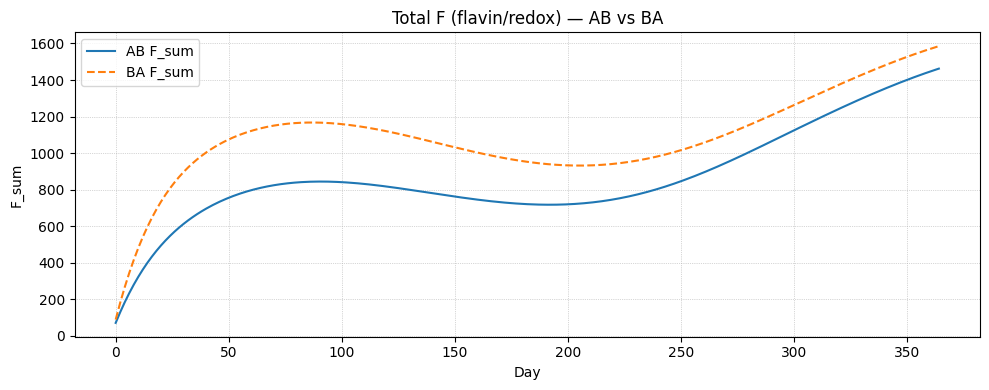

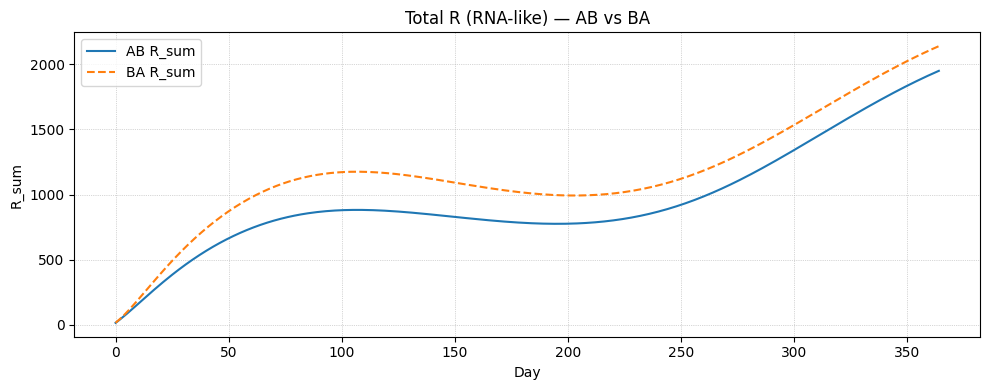

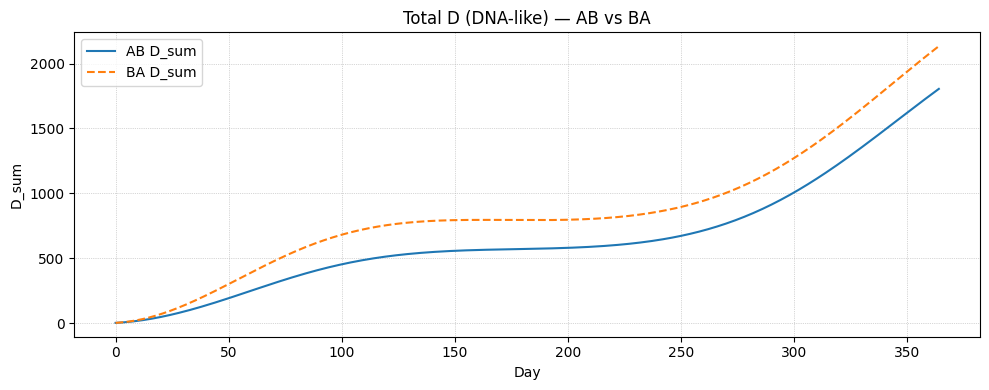

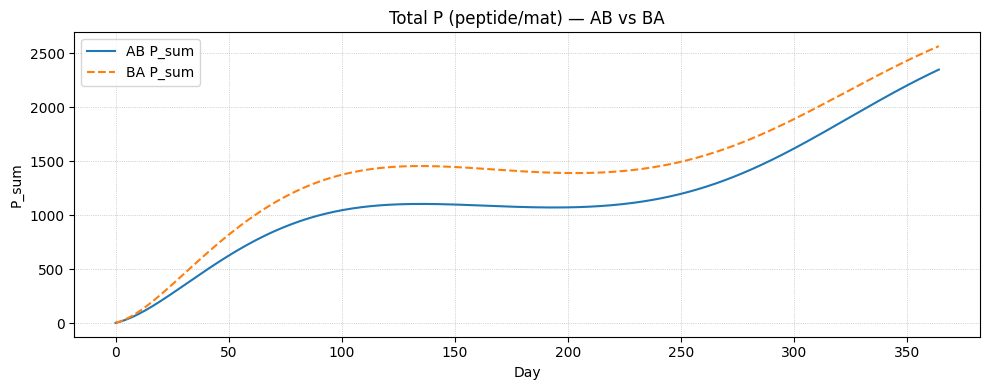

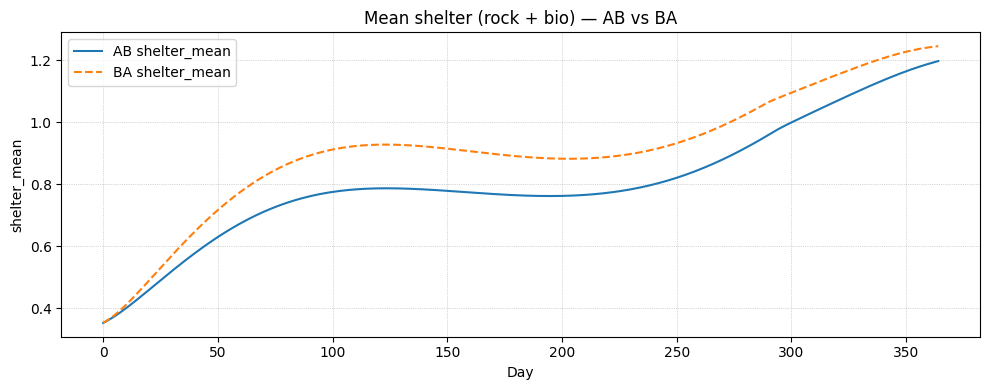


Event-order (first crossing days):
protocol  F_cross  R_cross  D_cross  P_cross
      AB       12       20       49       28
      BA        7       20       47       27


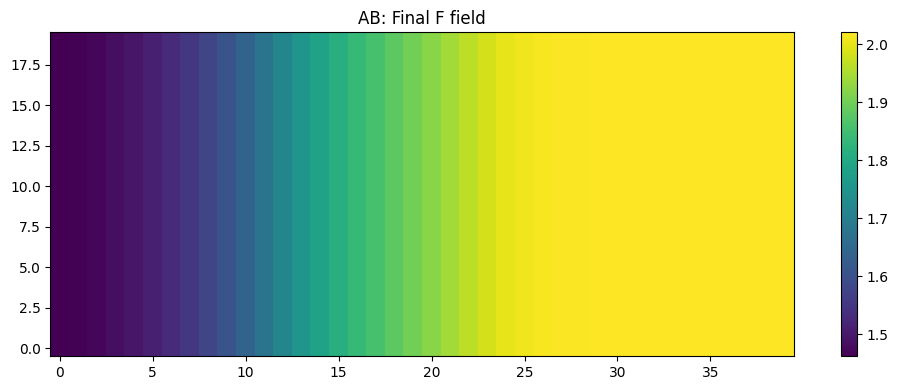

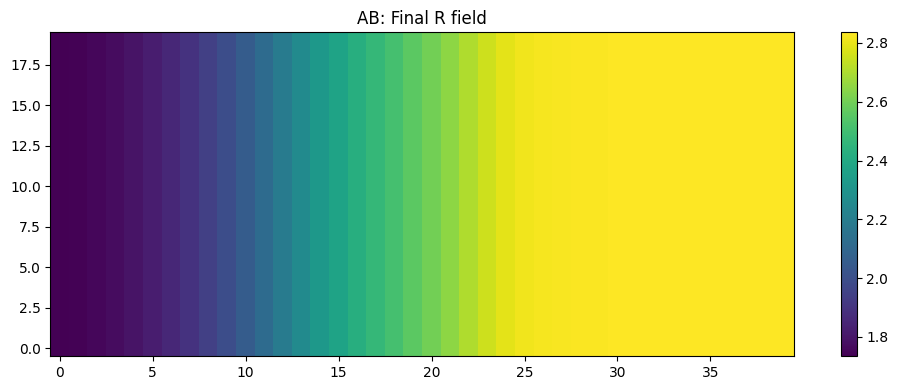

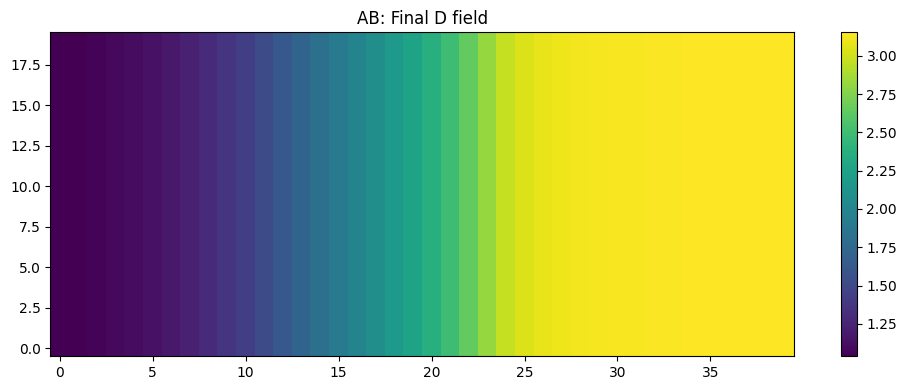

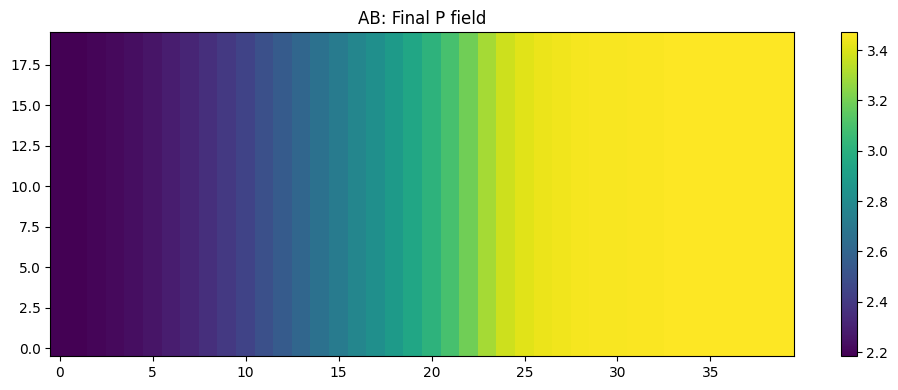

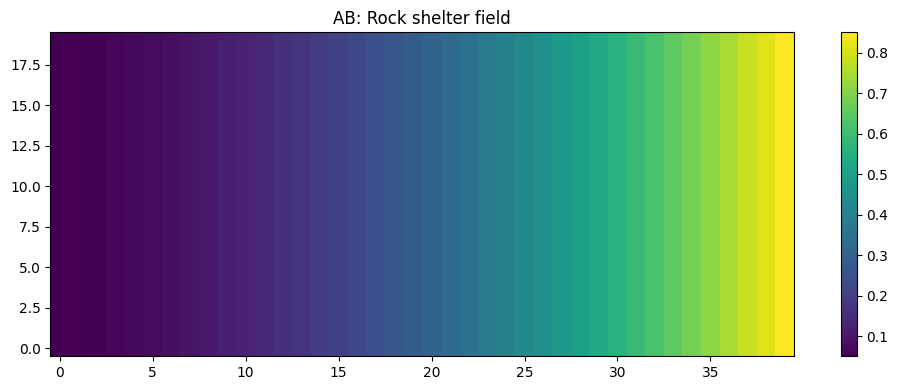

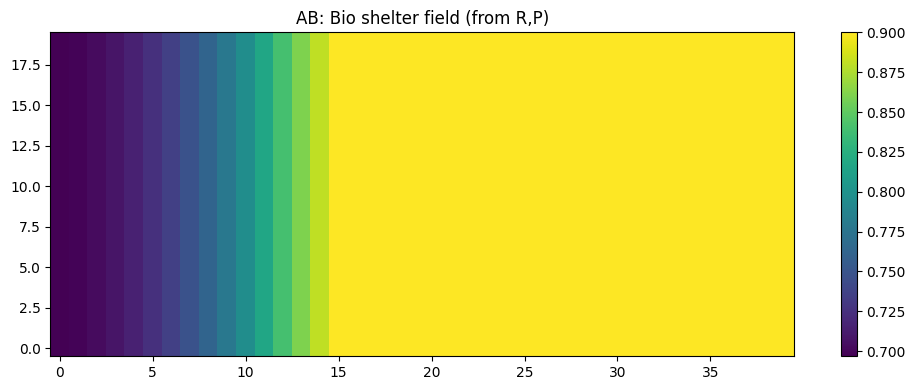

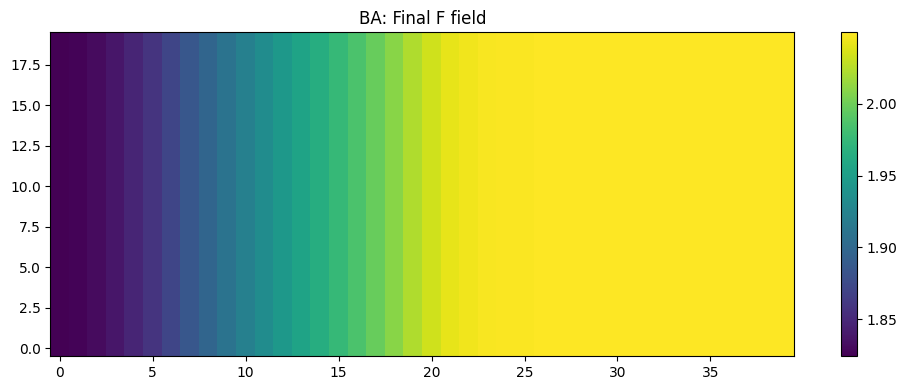

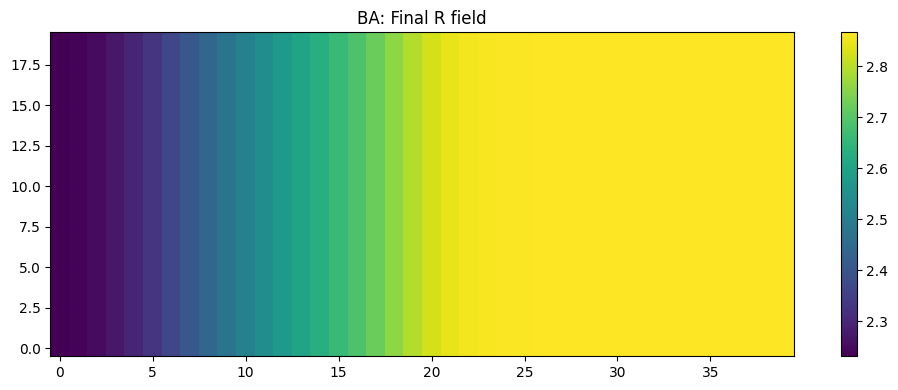

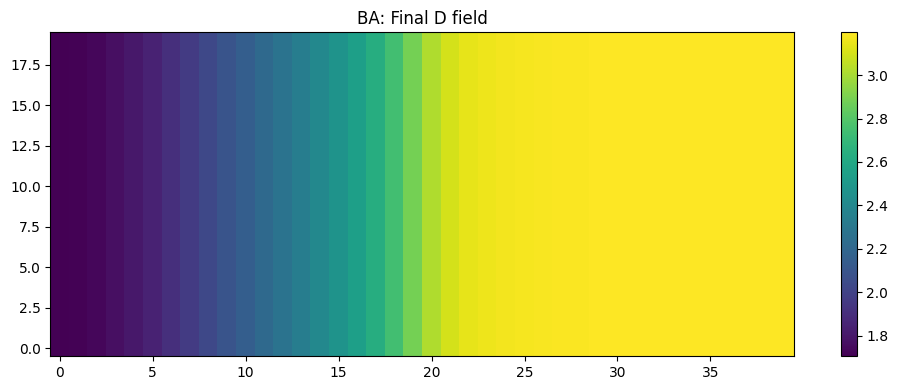

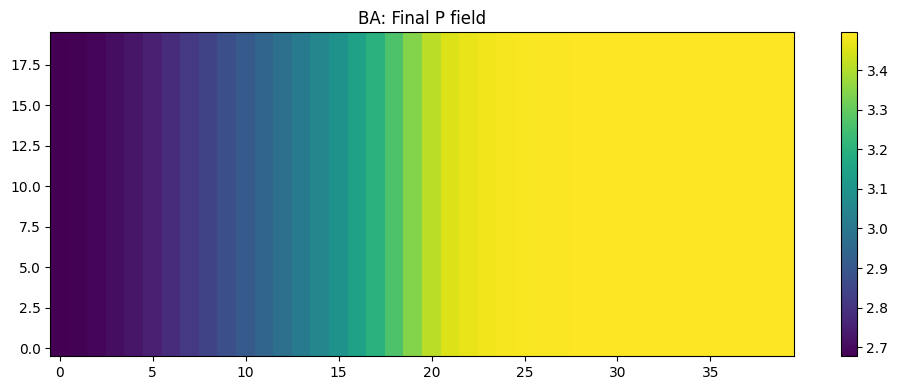

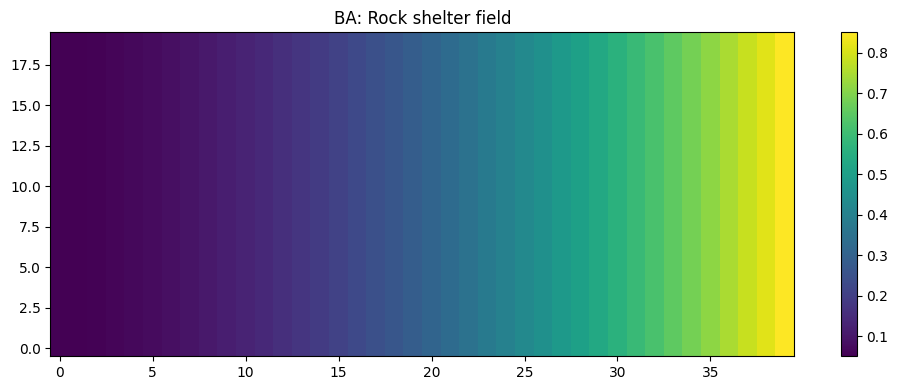

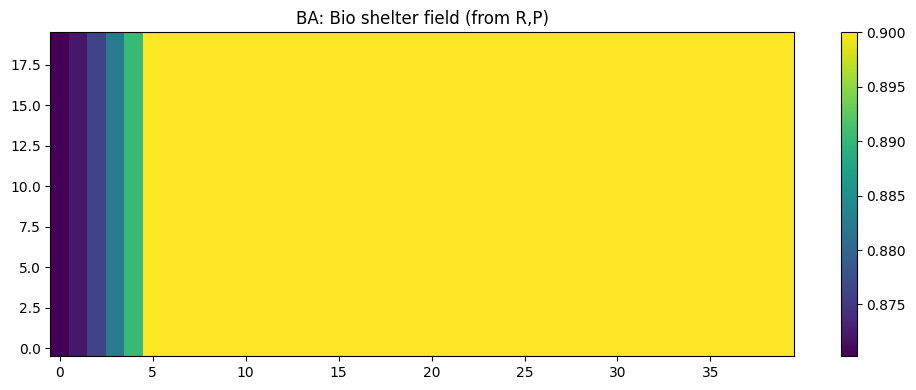

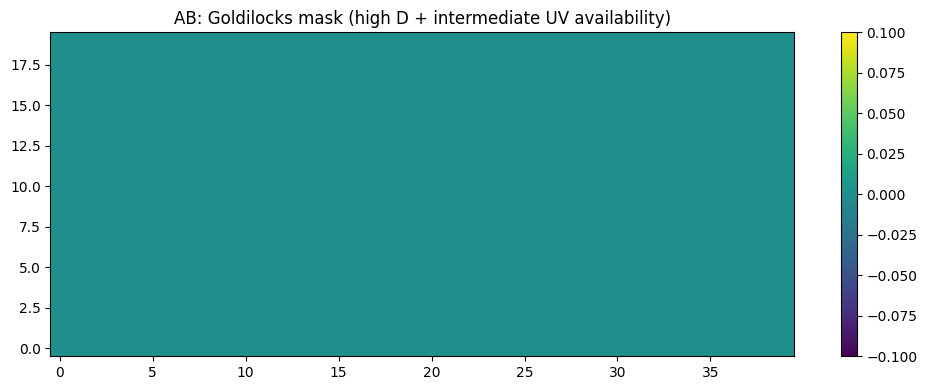

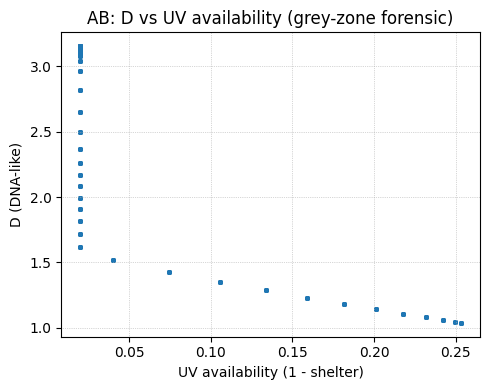

In [ ]:
# =========================
# BLOCK 2 — FORENSICS + GOLDILOCKS MAPS + ORDERING INFERENCE
# Loads the saved CSV/NPZ and generates:
#  - AB vs BA time series overlays (F,R,D,P)
#  - Event-order table (which emerged first)
#  - Final spatial maps (F,R,D,P) and shelter field
#  - Goldilocks heatmap: where D is high AND UV not too low AND shelter not too high
# =========================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

tag = "brainbox"

ab = pd.read_csv(f"{tag}_AB_daily.csv")
ba = pd.read_csv(f"{tag}_BA_daily.csv")

ab_ev = pd.read_csv(f"{tag}_AB_events.csv")
ba_ev = pd.read_csv(f"{tag}_BA_events.csv")

fields_ab = np.load(f"{tag}_AB_fields.npz")
fields_ba = np.load(f"{tag}_BA_fields.npz")

def plot_overlay(col, title):
    plt.figure(figsize=(10,4))
    plt.plot(ab["day"], ab[col], label=f"AB {col}")
    plt.plot(ba["day"], ba[col], label=f"BA {col}", linestyle="--")
    plt.xlabel("Day")
    plt.ylabel(col)
    plt.title(title)
    plt.grid(True, linestyle=":", linewidth=0.5)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Time series overlays
plot_overlay("F_sum", "Total F (flavin/redox) — AB vs BA")
plot_overlay("R_sum", "Total R (RNA-like) — AB vs BA")
plot_overlay("D_sum", "Total D (DNA-like) — AB vs BA")
plot_overlay("P_sum", "Total P (peptide/mat) — AB vs BA")
plot_overlay("shelter_mean", "Mean shelter (rock + bio) — AB vs BA")

# Event ordering summary
def event_order(ev_df):
    order = {}
    for key in ["F_cross","R_cross","D_cross","P_cross"]:
        sub = ev_df[ev_df["event"] == key]
        order[key] = int(sub["day"].min()) if len(sub) else None
    return order

order_ab = event_order(ab_ev)
order_ba = event_order(ba_ev)

order_df = pd.DataFrame([
    {"protocol":"AB", **order_ab},
    {"protocol":"BA", **order_ba},
])
print("\nEvent-order (first crossing days):")
print(order_df.to_string(index=False))

# Final field maps
def show_field(field, title):
    plt.figure(figsize=(10,4))
    plt.imshow(field, aspect="auto", origin="lower")
    plt.colorbar()
    plt.title(title)
    plt.tight_layout()
    plt.show()

for proto, fld in [("AB", fields_ab), ("BA", fields_ba)]:
    show_field(fld["F"], f"{proto}: Final F field")
    show_field(fld["R"], f"{proto}: Final R field")
    show_field(fld["D"], f"{proto}: Final D field")
    show_field(fld["P"], f"{proto}: Final P field")
    show_field(fld["rock_shelter"], f"{proto}: Rock shelter field")
    show_field(fld["bio_shelter"], f"{proto}: Bio shelter field (from R,P)")

# Goldilocks map (AB): D high but not total darkness and not total exposure
# We approximate UV availability by (1 - shelter) and wet by wet_season (global).
F = fields_ab["F"]; R = fields_ab["R"]; D = fields_ab["D"]; P = fields_ab["P"]
shelter = np.clip(fields_ab["rock_shelter"] + fields_ab["bio_shelter"], 0.0, 0.98)
uv_avail = 1.0 - shelter

# Define "goldilocks" as:
#  - D above a percentile threshold
#  - uv_avail in a middle band (not 0, not 1)
D_thr = np.quantile(D, 0.80) if np.any(D > 0) else 0.0
gold = (D >= D_thr) & (uv_avail >= 0.10) & (uv_avail <= 0.60)

plt.figure(figsize=(10,4))
plt.imshow(gold.astype(float), aspect="auto", origin="lower")
plt.title("AB: Goldilocks mask (high D + intermediate UV availability)")
plt.colorbar()
plt.tight_layout()
plt.show()

# Optional: overlay D and UV availability scatter to see “grey zone”
plt.figure(figsize=(5,4))
plt.scatter(uv_avail.flatten(), D.flatten(), s=6, alpha=0.5)
plt.xlabel("UV availability (1 - shelter)")
plt.ylabel("D (DNA-like)")
plt.title("AB: D vs UV availability (grey-zone forensic)")
plt.grid(True, linestyle=":", linewidth=0.5)
plt.tight_layout()
plt.show()

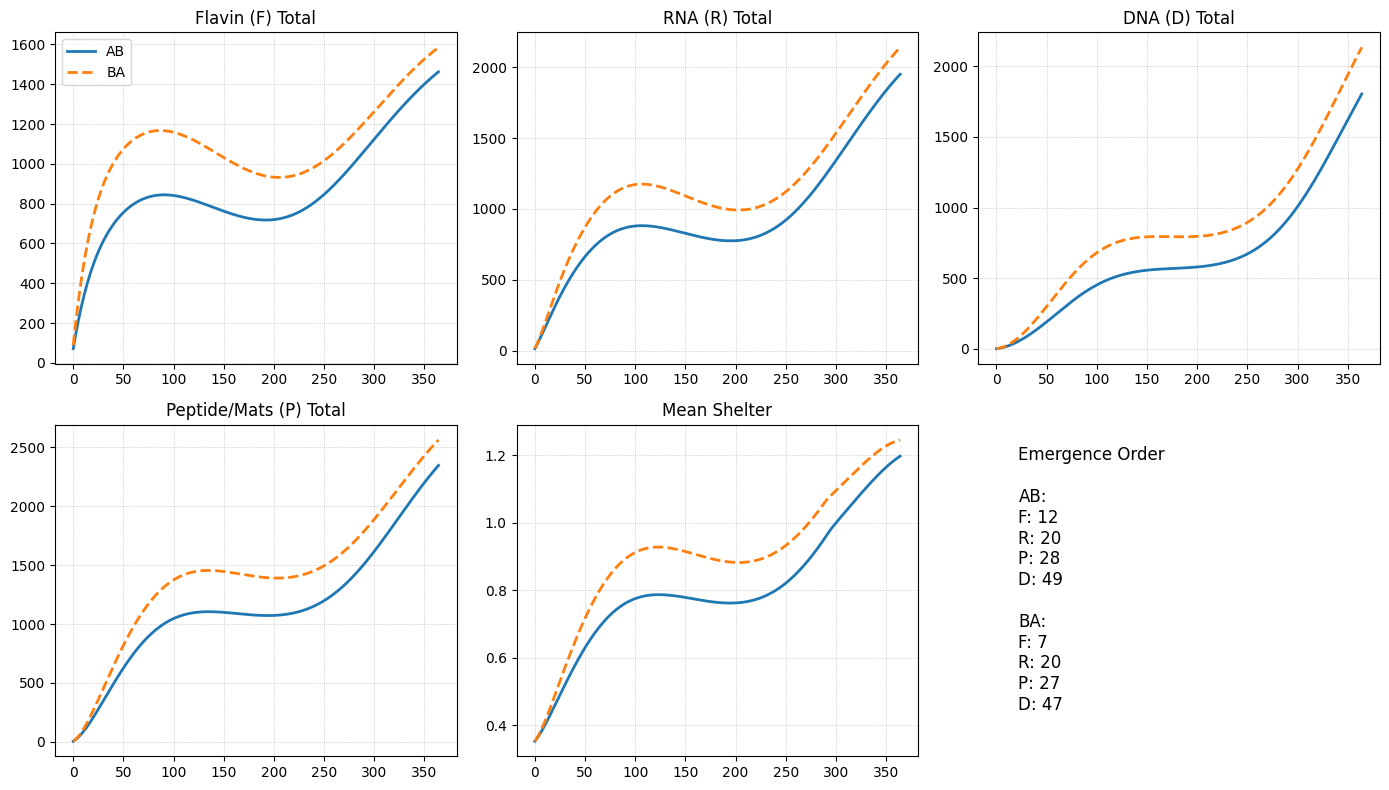

Saved: brainbox_summary_panel.png


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load data
ab = pd.read_csv("brainbox_AB_daily.csv")
ba = pd.read_csv("brainbox_BA_daily.csv")
ab_ev = pd.read_csv("brainbox_AB_events.csv")
ba_ev = pd.read_csv("brainbox_BA_events.csv")

def first_day(ev_df, key):
    sub = ev_df[ev_df["event"] == key]
    return int(sub["day"].min()) if len(sub) else None

# Extract first crossings
cross_keys = ["F_cross","R_cross","P_cross","D_cross"]
ab_cross = {k: first_day(ab_ev, k) for k in cross_keys}
ba_cross = {k: first_day(ba_ev, k) for k in cross_keys}

# Create panel
fig, axs = plt.subplots(2, 3, figsize=(14, 8))
axs = axs.flatten()

def plot_pair(ax, col, title):
    ax.plot(ab["day"], ab[col], label="AB", linewidth=2)
    ax.plot(ba["day"], ba[col], linestyle="--", label="BA", linewidth=2)
    ax.set_title(title)
    ax.grid(True, linestyle=":", linewidth=0.5)

# Top row
plot_pair(axs[0], "F_sum", "Flavin (F) Total")
plot_pair(axs[1], "R_sum", "RNA (R) Total")
plot_pair(axs[2], "D_sum", "DNA (D) Total")

# Bottom row
plot_pair(axs[3], "P_sum", "Peptide/Mats (P) Total")
plot_pair(axs[4], "shelter_mean", "Mean Shelter")

# Phase diagram panel (event ordering)
axs[5].axis("off")
text = "Emergence Order\n\n"
text += "AB:\n"
for k in cross_keys:
    text += f"{k.replace('_cross','')}: {ab_cross[k]}\n"
text += "\nBA:\n"
for k in cross_keys:
    text += f"{k.replace('_cross','')}: {ba_cross[k]}\n"

axs[5].text(0.1, 0.5, text, fontsize=12, verticalalignment="center")

# Legend
axs[0].legend(loc="upper left")

plt.tight_layout()
plt.savefig("brainbox_summary_panel.png", dpi=300)
plt.show()

print("Saved: brainbox_summary_panel.png")

In [ ]:
import numpy as np
import pandas as pd

from copy import deepcopy

def run_noF_brainbox(tag="brainbox_noF",
                      days=365,
                      steps_per_day=60,
                      nx=40,
                      ny=20,
                      rng_seed=42):

    rng = np.random.default_rng(rng_seed)

    # State fields (F removed)
    R = np.zeros((ny, nx))
    D = np.zeros((ny, nx))
    P = np.zeros((ny, nx))

    rock_shelter = np.linspace(0.05, 0.85, nx)
    rock_shelter = np.repeat(rock_shelter[np.newaxis,:], ny, axis=0)

    dt = 1.0 / steps_per_day
    half = steps_per_day // 2

    k_R_form = 0.05
    k_R_loss_uv = 0.08
    k_D_form = 0.02
    k_D_loss_uv = 0.12
    k_P_form = 0.03
    k_P_loss_uv = 0.03

    thr = {"R":0.5,"D":0.5,"P":0.5}
    first = {"R":None,"D":None,"P":None}

    for day in range(days):

        for step in range(steps_per_day):

            gate = "AB"[0] if step < half else "AB"[1]
            wet = 1.0 if gate == "A" else 0.0
            uv = 1.0 if gate == "B" else 0.0

            bio_shelter = np.clip(0.15*R + 0.20*P, 0, 0.9)
            shelter = np.clip(rock_shelter + bio_shelter, 0, 0.98)
            uv_eff = uv * (1 - shelter)

            # RNA
            dR = k_R_form * wet * (1 - R)
            lossR = k_R_loss_uv * uv_eff * R
            R = R + (dR - lossR) * dt

            # DNA
            dD = k_D_form * wet * R * (1 - D)
            lossD = k_D_loss_uv * uv_eff * D
            D = D + (dD - lossD) * dt

            # Peptide/mat
            dP = k_P_form * wet * R * (1 - P)
            lossP = k_P_loss_uv * uv_eff * P
            P = P + (dP - lossP) * dt

            R = np.maximum(R,0)
            D = np.maximum(D,0)
            P = np.maximum(P,0)

        if first["R"] is None and np.max(R) >= thr["R"]:
            first["R"] = day
        if first["P"] is None and np.max(P) >= thr["P"]:
            first["P"] = day
        if first["D"] is None and np.max(D) >= thr["D"]:
            first["D"] = day

    print("No-F first crossings:", first)
    return first

run_noF_brainbox()

No-F first crossings: {'R': 29, 'D': 114, 'P': 83}


{'R': 29, 'D': 114, 'P': 83}

In [ ]:
import pandas as pd
import numpy as np

def extract_order(events_df):
    order = {}
    for key in ["F_cross","R_cross","P_cross","D_cross"]:
        sub = events_df[events_df["event"] == key]
        order[key] = int(sub["day"].min()) if len(sub) else None
    return order

results = []

for seed in range(50):
    df_ab, ev_ab = run_brainbox(tag=f"mc_{seed}",
                                protocol="AB",
                                rng_seed=seed)

    order = extract_order(ev_ab)
    order["seed"] = seed
    results.append(order)

res_df = pd.DataFrame(results)

print("\nMonte Carlo ordering frequency:")
print(res_df[["F_cross","R_cross","P_cross","D_cross"]].value_counts())

res_df.to_csv("brainbox_montecarlo_50.csv", index=False)
print("Saved: brainbox_montecarlo_50.csv")

Saved: mc_0_AB_daily.csv mc_0_AB_events.csv mc_0_AB_fields.npz
First crossings (day): {'F': 12, 'R': 20, 'D': 49, 'P': 28}
Saved: mc_1_AB_daily.csv mc_1_AB_events.csv mc_1_AB_fields.npz
First crossings (day): {'F': 12, 'R': 20, 'D': 49, 'P': 28}
Saved: mc_2_AB_daily.csv mc_2_AB_events.csv mc_2_AB_fields.npz
First crossings (day): {'F': 12, 'R': 20, 'D': 49, 'P': 28}
Saved: mc_3_AB_daily.csv mc_3_AB_events.csv mc_3_AB_fields.npz
First crossings (day): {'F': 12, 'R': 20, 'D': 49, 'P': 28}
Saved: mc_4_AB_daily.csv mc_4_AB_events.csv mc_4_AB_fields.npz
First crossings (day): {'F': 12, 'R': 20, 'D': 49, 'P': 28}
Saved: mc_5_AB_daily.csv mc_5_AB_events.csv mc_5_AB_fields.npz
First crossings (day): {'F': 12, 'R': 20, 'D': 49, 'P': 28}
Saved: mc_6_AB_daily.csv mc_6_AB_events.csv mc_6_AB_fields.npz
First crossings (day): {'F': 12, 'R': 20, 'D': 49, 'P': 28}
Saved: mc_7_AB_daily.csv mc_7_AB_events.csv mc_7_AB_fields.npz
First crossings (day): {'F': 12, 'R': 20, 'D': 49, 'P': 28}
Saved: mc_8_AB_d